In [1]:
import sys
sys.path.append('n_dim_code/')
sys.path.append('/Users/will_milligan/PycharmProjects/Laura/')
import pickle
import numpy as np

import os
import warnings

import matplotlib as mpl
from matplotlib import pyplot as plt

from collections import defaultdict as ddict
from collections import OrderedDict as odict
from collections import namedtuple as nt
from scipy.optimize import minimize_scalar
from scipy.optimize import root
from math import erf

from scipy import stats
from scipy.integrate import quad
from scipy.optimize import broyden1 as minimize
from scipy.interpolate import interp1d
from scipy.interpolate import griddata
from scipy.integrate import simpson
from scipy.special import dawsn
from scipy.special import erfi
from scipy.optimize import root
from scipy import ndimage

from matplotlib import patches
from matplotlib import text as mtext
import math

import laura_equations as cf
# import mutation_class_n_dim

cmap = mpl.cm.get_cmap('Greys')
norm = mpl.colors.LogNorm(vmin=1/np.sqrt(400*1.7), vmax=100)
norm = mpl.colors.Normalize(vmin=1,vmax=100)
N = 5000
small_var_per_mutational_input =1.48


In [2]:
# with open('/Users/will_milligan/PycharmProjects/Laura/snakemake_figures/sdist_expon/N2U_fixations_contour_single_shift_results.pickle','rb') as fin:
#     results = pickle.load(fin)
# with open('/Users/will_milligan/PycharmProjects/Laura/snakemake_figures/sdist_expon/new_N2U_fixations_contour_results.pickle','rb') as fin:
#     results = pickle.load(fin)
    
    
# with open('/Users/will_milligan/Desktop/N2U_fixations_contour_shift_results.02052025.pickle','rb') as fin:
#     results_shift = pickle.load(fin)
    
    
# with open('/Users/will_milligan/PycharmProjects/Laura/snakemake_figures/sdist_expon/N2U_fixations_contour_results.pickle','rb') as fin:
#     results_multiple_shifts = pickle.load(fin)

with open('/Users/will_milligan/PycharmProjects/Laura/snakemake_figures/sdist_expon/new_N2U_fixations_contour_results.pickle','rb') as fin:
    results_A80 = pickle.load(fin)
    
with open('/Users/will_milligan/Desktop/Sella/new_N2U_fixations_contour_shift50_results.pickle','rb') as fin:
    results_A50 = pickle.load(fin)
    
with open('/Users/will_milligan/Desktop/2NU>>1/N2U_fixations_contour_shift_results.02052025.pickle','rb') as fin:
    results_B = pickle.load(fin)

with open('/Users/will_milligan/Desktop/Sella/shift_80_alt_parameters_concat_over_shift_values_new.pickle.gz','rb') as fin:
    results_C_80 = pickle.load(fin)
    
with open('/Users/will_milligan/Desktop/Sella/p_0.5_alt_parameters_concat_over_shift_values.pickle.gz','rb') as fin:
    results_D_05 = pickle.load(fin)
    
with open('/Users/will_milligan/Desktop/Sella/p_0.1_alt_parameters_concat_over_shift_values.pickle.gz','rb') as fin:
    results_D_01 = pickle.load(fin)
    
with open('/Users/will_milligan/Desktop/Sella/shift_50_alt_parameters_concat_over_shift_values.pickle.gz','rb') as fin:
    results_C_50 = pickle.load(fin)
    
results_D = {0.1:results_D_01, 0.5:results_D_05}
results_C = {80:results_C_80, 50:results_C_50}
results_A = {80:results_A80[80], 50:results_A50[50]}


    

In [3]:
### This is code to draw curved text on a plot
### Difficult to adapt to log scale

class CurvedText(mtext.Text):
    """
    A text object that follows an arbitrary curve.
    """
    def __init__(self, x, y, text, axes, color,**kwargs):
        super(CurvedText, self).__init__(x[0],y[0],' ', **kwargs)

        axes.add_artist(self)

        ##saving the curve:
        self.__x = x
        self.__y = y
        self.__zorder = self.get_zorder()

        ##creating the text objects
        self.__Characters = []
        for c in text:
            if c == ' ':
                ##make this an invisible 'a':
                t = mtext.Text(0,0,'a')
                t.set_alpha(0.0)
            else:
                t = mtext.Text(0,0,c,color=color, **kwargs)

            #resetting unnecessary arguments
            t.set_ha('center')
            t.set_rotation(0)
            t.set_zorder(self.__zorder +1)
            
            self.__Characters.append((c,t))
            axes.add_artist(t)


    ##overloading some member functions, to assure correct functionality
    ##on update
    def set_zorder(self, zorder):
        super(CurvedText, self).set_zorder(zorder)
        self.__zorder = self.get_zorder()
        for c,t in self.__Characters:
            t.set_zorder(self.__zorder+1)

    def draw(self, renderer, *args, **kwargs):
        """
        Overload of the Text.draw() function. Do not do
        do any drawing, but update the positions and rotation
        angles of self.__Characters.
        """
        self.update_positions(renderer)

    def update_positions(self,renderer):
        """
        Update positions and rotations of the individual text elements.
        """
        #preparations

        ##determining the aspect ratio:
        ##from https://stackoverflow.com/a/42014041/2454357
        
        ##Determine the scale of each axis
        yscale = self.axes.get_yscale()
        xscale = self.axes.get_xscale()
        
        if yscale == 'linear':
            ylog = False
        elif yscale == 'log':
            ylog = True
        else:
            raise ValueError('Unknown scale for y-axis: {}'.format(yscale))
        if xscale == 'linear':
            xlog = False
        elif xscale == 'log':
            xlog = True
        else:
            raise ValueError('Unknown scale for x-axis: {}'.format(xscale))
        
        ##data limits
        xlim = self.axes.get_xlim()
        ylim = self.axes.get_ylim()
  
        ## Axis size on figure
        figW, figH = self.axes.get_figure().get_size_inches()
        ## Ratio of display units
        _, _, w, h = self.axes.get_position().bounds
        ##final aspect ratio
        if ylog:
            ypart = np.log10(ylim[1])-np.log10(ylim[0])
        else:
            ypart = ylim[1]-ylim[0]
        if xlog:
            xpart = np.log10(xlim[1])-np.log10(xlim[0])
        else:
            xpart = xlim[1]-xlim[0]
        aspect = ((figW * w)/(figH * h))*(ypart/xpart)

        #points of the curve in figure coordinates:
        x_fig,y_fig = (
            np.array(l) for l in zip(*self.axes.transData.transform([
            (i,j) for i,j in zip(self.__x,self.__y)
            ]))
        )
        
                
        #point distances in figure coordinates
        x_fig_dist = (x_fig[1:]-x_fig[:-1])
        y_fig_dist = (y_fig[1:]-y_fig[:-1])
        r_fig_dist = np.sqrt(x_fig_dist**2+y_fig_dist**2)
        
        #arc length in figure coordinates
        l_fig = np.insert(np.cumsum(r_fig_dist),0,0)


        #angles in figure coordinates
        rads = np.arctan2((y_fig[1:] - y_fig[:-1]),(x_fig[1:] - x_fig[:-1]))
        degs = np.rad2deg(rads)
        rel_pos = 0
        for c,t in self.__Characters:
            #finding the width of c:
            t.set_rotation(0)
            t.set_va('center')
            bbox1  = t.get_window_extent(renderer=renderer)
            w = bbox1.width
            h = bbox1.height

            #ignore all letters that don't fit:
            if rel_pos+w/2 > l_fig[-1]:
                
                t.set_alpha(0.0)
                rel_pos += w
                
                continue

            elif c != ' ':
                t.set_alpha(1.0)

            #finding the two data points between which the horizontal
            #center point of the character will be situated
            #left and right indices:
            
            il = np.where(rel_pos+w/2 >= l_fig)[0][-1]
            ir = np.where(rel_pos+w/2 <= l_fig)[0][0]
            
            #if we exactly hit a data point:
            if ir == il:
                ir += 1

            #how much of the letter width was needed to find il:
            used = l_fig[il]-rel_pos
            rel_pos = l_fig[il]
            #relative distance between il and ir where the center
            #of the character will be
            fraction = (w/2-used)/r_fig_dist[il]
            

            ##setting the character position in data coordinates:
            ##interpolate between the two points:
            if xlog:
                x = 10**(np.log10(self.__x[il])+fraction*(np.log10(self.__x[ir])-np.log10(self.__x[il])))
            else:
                x = self.__x[il]+fraction*(self.__x[ir]-self.__x[il])
                
            if ylog:
                y = 10**(np.log10(self.__y[il])+fraction*(np.log10(self.__y[ir])-np.log10(self.__y[il])))
            else:
                y = self.__y[il]+fraction*(self.__y[ir]-self.__y[il])
                
            
            
            #getting the offset when setting correct vertical alignment
            #in data coordinates
            t.set_va(self.get_va())
            bbox2  = t.get_window_extent(renderer=renderer)
            
            bbox1d = self.axes.transData.inverted().transform(bbox1)
            bbox2d = self.axes.transData.inverted().transform(bbox2)
            dr = np.array(bbox2d[0]-bbox1d[0])

            #the rotation/stretch matrix
            rad = rads[il]
          
            rot_mat = np.array([
                [math.cos(rad), math.sin(rad)*aspect],
                [-math.sin(rad)/aspect, math.cos(rad)]
            ])

            ##computing the offset vector of the rotated character
            drp = [0,0]#np.dot(dr,rot_mat)
           
            #setting final position and rotation:
            x_final = x+drp[0]
            y_final = y+drp[1]+ypart/100*5
            t.set_position((x_final,y_final))
            t.set_rotation(degs[il])

            # print(x,y,x_final,y_final,degs[il])
            
            t.set_va('center')
            t.set_ha('center')
            
            #updating rel_pos to right edge of character
            rel_pos += w-used


## linearly interpolate along a given curve of x,y points
def interpolate_curve(new_x,x, y):
    il = np.where(new_x >= x)[0][-1]
    ir = np.where(new_x <= x)[0][0]
    
    yl = y[il]
    yr = y[ir]
    new_y = yl + (yr-yl)*(new_x-x[il])/(x[ir]-x[il])
    return new_y
    



In [4]:
# Find the closest value in a dictionary

def find_closest_values(key,key_dict):
    key_value = 0
    if key in key_dict.keys():
        value = key_dict[key][key_value]
    elif key > 300:
        value = 0
    else:
        upper_key = 1000
        lower_key = 0
        for key_key in key_dict.keys():
            if np.isnan(key_key):
                continue
            else:
                if key_key > key and key_key < upper_key:
                    upper_key = key_key
                if key_key < key and key_key > lower_key:
                    lower_key = key_key
            
        if upper_key == 1000:
            value = key_dict[lower_key][key_value]
        elif lower_key == 0:
            value = key_dict[upper_key][key_value]
        else:
            value = (key_dict[upper_key][key_value])
    return value
    
# transform the results into a format that can be plotted
# returns a vector of the x and y values and a dictionary of the result matrix {z: matrix}
def process_results(results):
    
    unique_x_values = set()
    N2U_values = set()
    for key in results.keys():
        for N2U in results[key].keys():
            N2U_values.add(N2U)
            x_temp = np.sort(list(results[key][N2U].keys()))
            unique_x_values.update([x for x in x_temp if not np.isnan(x)])

    Y_all_results = {}
    for key in results.keys():
    
        Y_all = []
        for N2U in np.sort(list(results[key].keys())):
            y_temp = []
            for x in np.sort(list(unique_x_values)):
                value = find_closest_values(key=x,key_dict=results[key][N2U])
                y_temp.append(find_closest_values(key=x,key_dict=results[key][N2U]))
                # if key == 80:
                    
                    # if x > 190:
                    #     y_temp[-1] = 0
                # if N2U > 450:
                #     y_temp.append(0)
                # else:
                
            Y_all.append(y_temp)
        Y_all_results[key] = Y_all

    unique_x_values = np.sort(list(unique_x_values))
    unique_x_values[0]=0
    N2U_values = list(np.sort(list(N2U_values)))
    return N2U_values,unique_x_values,Y_all_results


In [5]:
N2U_values,unique_x_values,Y_all_results = process_results(results)
Y_all=(Y_all_results[80])
N2U_values_shift,unique_x_values_shift,Y_all_results_shift = process_results(results_shift)


NameError: name 'results' is not defined

In [6]:
def find_closest_values_shift(sigma2,sigma2_dict,shift,mode='fixations'):

    if sigma2 in sigma2_dict.keys():
        if mode == 'fixations':
            return sigma2_dict[sigma2][0]
        else:
            return sigma2_dict[sigma2][-1]
    elif sigma2 > 300:
        return 0
    else:
        upper_sigma2 = 1000
        lower_sigma2 = 0
        for sigma2_key in sigma2_dict.keys():
            if np.isnan(sigma2_key):
                continue
            else:
                if sigma2_key > sigma2 and sigma2_key < upper_sigma2:
                    upper_sigma2 = sigma2_key
                if sigma2_key < sigma2 and sigma2_key > lower_sigma2:
                    lower_sigma2 = sigma2_key
#         print(sigma2_dict[lower_sigma2])
        if upper_sigma2 == 1000:
            if mode == 'fixations':
                return sigma2_dict[lower_sigma2][0]
            else:
                return sigma2_dict[lower_sigma2][-1]
        elif lower_sigma2 == 0:
            if mode == 'fixations':
                return sigma2_dict[upper_sigma2][0]
            else:
                return sigma2_dict[upper_sigma2][-1]
        else:
            if mode == 'fixations':
                return sigma2_dict[upper_sigma2][0]
            else:
                return sigma2_dict[upper_sigma2][-1]
            
def process_results_shift(results,mode='fixations'):
    unique_x_values = set()
    N2U_values = set()
    for shift in results.keys():
        for N2U in results[shift].keys():
            N2U_values.add(N2U)
            x_temp = np.sort(list(results[shift][N2U].keys()))
            unique_x_values.update([x for x in x_temp if not np.isnan(x)])

    Y_all_results = {}
    for shift in results.keys():
        Y_all = []
        for N2U in np.sort(list(results[shift].keys())):
            y_temp = []
            for x in np.sort(list(unique_x_values)):
                if N2U > 450:
    #                 print(N2U)
                    y_temp.append(0)
                else:
                    y_temp.append(find_closest_values_shift(sigma2=x,sigma2_dict=results[shift][N2U],shift=shift,mode=mode))
            Y_all.append(y_temp)
        Y_all_results[shift] = Y_all
    return N2U_values,unique_x_values, Y_all_results



In [7]:
def plot_contour(ax, N2U_values, unique_x_values, Y_all,raw = False,mode='fixations',normalize = 1):
    plt.sca(ax)
    cmap = mpl.cm.get_cmap('Greys')
    
    if mode == 'fixations' or normalize != 1:
        norm = mpl.colors.Normalize(vmin=0, vmax=1)
        levels = [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
        sigma = [1.5,1]
    else:
        norm = mpl.colors.Normalize(vmin=1, vmax=100)
        levels = [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
        sigma = [1.5,1]
    
    # prepare data for drawing contours
    Z = np.flip(np.transpose(np.flipud(Y_all)))/normalize
    Z2 = ndimage.gaussian_filter(np.flip(Z), sigma=sigma, order=0, mode='nearest',truncate=1)
    
    # if only drawing smoothed contours, 
    if not raw:
        plt.contourf(np.sort(list(N2U_values)), np.sort(list(unique_x_values)), np.fliplr(Z2),
                    levels, cmap=cmap, alpha=1, algorithm='serial',norm=norm)
    else:
        plt.pcolormesh(np.sort(list(N2U_values)), np.sort(list(unique_x_values)), np.fliplr(np.transpose(np.flipud(Y_all)))/normalize, cmap=cmap, norm=norm)
        
    # for all plots draw a single contour line,
    if mode == 'fixations' or normalize != 1:
        contour_line = plt.contour(np.sort(list(N2U_values)), np.sort(list(unique_x_values)), np.fliplr(Z2),
            [0.1], colors='r', linewidths=2)
        return np.sort(list(N2U_values)), np.sort(list(unique_x_values)), np.fliplr(Z2)
    else:
        contour_line = plt.contour(np.sort(list(N2U_values)), np.sort(list(unique_x_values)), np.fliplr(Z2),
            [20], colors='r', linewidths=2)
        

def make_panel_A(ax, results_A, chosen_shift,mode='fixations',raw=False):
    plt.sca(ax)
    N2U_values,unique_x_values, Y_all_results = process_results_shift(results_A,mode=mode)
    Y_all = Y_all_results[chosen_shift]
    unique_x_values.remove(min(unique_x_values))
    unique_x_values.add(0)
    N2U_values = 2*np.sort(list(N2U_values))
    if mode != 'fixations':
        normalize = 1
    else:
        normalize = 1
    contour_line = plot_contour(ax, N2U_values, unique_x_values, Y_all,raw=raw,mode=mode,normalize=normalize)
    ax.set_title(r'$\sigma^2$ contours', loc='left')
    ax.set_xlim([1e-3, 1e3])
    ax.set_ylim([0, 250])
    ax.set_xticks([1e-3, 1e-2, 1e-1, 1, 10, 100, 1000])
    ax.set_xticklabels(['$10^{-3}$', '$10^{-2}$', '$10^{-1}$', '$10^{0}$', '$10^{1}$', '$10^{2}$', '$10^{3}$'])
    ax.set_yticks([0, 50, 100, 150, 200])
    ax.set_yticklabels(['0', '50', '100', '150', '200'])
    ax.set_ylabel(r'Background variance $\sigma^2$')
    ax.set_xlabel(r'Mutational input $2NU$')
    ax.set_xscale('log')
    return contour_line

def make_panel_B(ax, results_B, chosen_sigma2,mode='fixations',raw=False):
    N2U_values,unique_x_values, Y_all_results = process_results_shift(results_B,mode=mode)
    plt.sca(ax)
    Y_all = Y_all_results[chosen_sigma2]
    N2U_values = 2*np.sort(list(N2U_values))
    contour_line = plot_contour(ax, N2U_values, unique_x_values, Y_all,raw=raw,mode=mode)
    ax.set_title(r'$2NU$ contours', loc='left')
    ax.set_xlim([1e-3, 1e3])
    ax.set_ylim([0, 100])
    ax.set_xticks([1e-3, 1e-2, 1e-1, 1, 10, 100, 1000])
    ax.set_xticklabels(['$10^{-3}$', '$10^{-2}$', '$10^{-1}$', '$10^{0}$', '$10^{1}$', '$10^{2}$', '$10^{3}$'])
    ax.set_yticks([0, 25, 50, 75, 100])
    ax.set_yticklabels(['0', '25', '50', '75', '100'])
    ax.set_ylabel(r'Shift size $\Lambda$')
    ax.set_xlabel(r'Mutational input $2NU$')
    ax.set_xscale('log')
    return contour_line

def make_panel_C(ax, results_C,mode='fixations',chosen_shift=80,raw=False):
    x_values = set()
    y_values = set()
    new_dict = {chosen_shift: {}}
    results_C_subset = results_C[chosen_shift]
    for N2U in results_C_subset.keys():
        for sigma2 in results_C_subset[N2U].keys():
            var = round(N2U*4+sigma2,5)
            large_var = N2U*4
            p = round(large_var/var,5)
            x_values.add(p)
            y_values.add(var)
            
                
            if p not in new_dict[chosen_shift].keys():
                new_dict[chosen_shift][p] = {}
            if var not in new_dict[chosen_shift][p].keys():
                new_dict[chosen_shift][p][var] = []
            new_dict[chosen_shift][p][var]=results_C_subset[N2U][sigma2][chosen_shift]
            
            if 1 not in new_dict[chosen_shift].keys():
                new_dict[chosen_shift][1] = {}
                x_values.add(1)
            if var not in new_dict[chosen_shift][1].keys():
                new_dict[chosen_shift][1][var] = [1,1,chosen_shift]
                
            if 0 not in new_dict[chosen_shift].keys():
                new_dict[chosen_shift][0] = {}
                x_values.add(0)
            if var not in new_dict[chosen_shift][0].keys():
                new_dict[chosen_shift][0][var] = [0,1,0]
 
    
    Y_all_results = {}
    for shift in new_dict.keys():
        Y_all = []
        for p in np.sort(list(new_dict[shift].keys())):
            y_temp = []
            for x in np.sort(list(new_dict[shift][p].keys())):
                if mode == 'fixations':
                    y_temp.append(new_dict[shift][p][x][0]/new_dict[shift][p][x][1])
                else:
                    y_temp.append(new_dict[shift][p][x][2])
            Y_all.append(y_temp)
        Y_all_results[shift] = Y_all
    Y_all = Y_all_results[chosen_shift]
    contour_line = plot_contour(ax, x_values, y_values,Y_all,raw=raw,mode=mode)
    return contour_line

def make_panel_D(ax, results_D,mode='fixations',chosen_p=0.5,raw=False):
    x_values = set()
    y_values = set()
    
    new_dict = {chosen_p: {}}
    for p in results_D.keys():
        if p != chosen_p:
            continue
        for N2U in results_D[p].keys():
            for sigma2 in results_D[p][N2U].keys():
                for shift in results_D[p][N2U][sigma2].keys():
                    
                    fixed, trials, adaptation = results_D[chosen_p][N2U][sigma2][shift]
                
                    var = round(N2U*4+sigma2,5)
                    shift_use = round(shift/np.sqrt(var),5)
                    x_values.add(round(var,5))
                    y_values.add(shift_use)
                    
                    if var not in new_dict[chosen_p].keys():
                        new_dict[chosen_p][var] = {}
                    if shift_use not in new_dict[chosen_p][var].keys():
                        new_dict[chosen_p][var][shift_use] = []
                    
                    new_dict[chosen_p][var][shift_use] = [fixed, trials, adaptation]
    
    Y_all_results = {}
    for p in new_dict.keys():
        Y_all = []
        for var in np.sort(list(new_dict[p].keys())):
            y_temp = []
            largest_shift_less_than_100 = max([ssss for ssss in np.sort(list(new_dict[p][var].keys())) if ssss*np.sqrt(var) < 100])
            for shift in np.sort(list(new_dict[p][var].keys())):
                if shift*np.sqrt(var) > 100:
                    shift_temp = largest_shift_less_than_100
                else:
                    shift_temp = shift
                    
                if mode == 'fixations':
                    try:
                        y_temp.append(new_dict[p][var][shift_temp][0]/new_dict[p][var][shift_temp][1])
                    except ZeroDivisionError:
                        y_temp.append(y_temp[-1])
                else:
                    y_temp.append(new_dict[p][var][shift_temp][2])
                    print('Da',shift*np.sqrt(var),shift_temp,new_dict[p][var][shift_temp][2])
            Y_all.append(y_temp)
        Y_all_results[p] = Y_all

    Y_all = Y_all_results[p]
    contour_line = plot_contour(ax, x_values, y_values,Y_all,raw=raw,mode=mode)
    x_values = np.linspace(1,1000,1000)
    y_values = 100/np.sqrt(x_values)
    ax.fill_between(x_values,y_values,100,color=[0.8,0.9,0.8],alpha=1,zorder=100)
    ax.text(200, 9, r'$\Lambda > \sqrt{V_S}$', fontsize=11, color='darkgreen', ha='center',zorder=101)
    return contour_line


In [8]:
# results_B=results_shift, chosen_sigma2=80,mode='fixations')
#     make_panel_A(a, results_A=results_multiple_shifts
def make_contour_plot_figure(results_A,results_B,results_C,results_D,chosen_shiftA=80,chosen_sigma2=80,chosen_p=0.5,chosen_shiftC=80,mode='fixations',raw=False,height_in=6.5):
    """
    Make the contour plot figure with panels A, B, C and D.
    """
    cmap = mpl.cm.get_cmap('Greys')
    plt.style.use('default')
    plt.rcParams['font.family'] = 'Arial'
    plt.rcParams['font.size'] = 11
    plt.rcParams['axes.labelsize'] = 11
    plt.rcParams['axes.titlesize'] = 11
    plt.rcParams['xtick.labelsize'] = 11
    plt.rcParams['ytick.labelsize'] = 11
    plt.rcParams['legend.fontsize'] = 11
    plt.rcParams['figure.titlesize'] = 11
    fontsize=11
    from matplotlib.patches import Rectangle, FancyBboxPatch
    facecolor=[0.92,0.95,1]
    # fig,axes_all = plt.subplots(ncols=5,nrows=2,dpi=500,figsize=(7.5,6.7),gridspec_kw={'width_ratios':[24,8,24,4,2]})
    # fig, axes_all = plt.subplot_mosaic("ABC;HHH;DEF;GGG;III",figsize=(6.5,7.3),dpi=400,gridspec_kw={'width_ratios': [24,8,24],'height_ratios':[24,10,24,8,2]})
    fig = plt.figure(figsize=(6.5,height_in),dpi=400)
    z = fig.add_axes(rect=[0,0,1,1])
    z.set_xticks([])
    z.set_yticks([])

    r = fig.canvas.get_renderer()
    t = z.text(0.5,0.5,'Figure 6',fontsize=fontsize,ha='center',va='center')
    bb = t.get_window_extent(renderer=r)
    width = bb.width
    height = bb.height/fig.dpi
    text_pad = height/8
    t.remove()
    z.remove()
    
    space_between_axes = 0.02
    space_between_colorbar = 0.1
    horizontal_space_between_axes=0.04
    colorbar = fig.add_axes(rect=[0.25,3*text_pad,0.5,0.2/8])
    current_y = 0.2/8+3*text_pad + space_between_colorbar
    max_y = 1-3.5*text_pad
    remaining_height = max_y-current_y
    min_x = 8*text_pad
    max_x = 1#-text_pad

    height = (remaining_height-3*text_pad-space_between_axes)/2

    c = fig.add_axes(rect=[min_x,current_y,height,height])
    d = fig.add_axes(rect=[min_x+height+horizontal_space_between_axes+text_pad*4,current_y,height,height])
    current_y += height+space_between_axes+3*text_pad
    a = fig.add_axes(rect=[min_x,current_y,height,height])
    b = fig.add_axes(rect=[min_x+height+horizontal_space_between_axes+text_pad*4,current_y,height,height])


    a.set_title(r'$\bf{A.}$',fontsize=fontsize,loc='left')
    a.set_ylabel('Background variance',fontsize=fontsize,labelpad=0)
    a.set_xlabel('Mutational input',fontsize=fontsize,labelpad=0)

    b.set_title(r'$\bf{B.}$',fontsize=fontsize,loc='left')
    b.set_ylabel('Shift size',fontsize=fontsize,labelpad=0)
    b.set_xlabel('Mutational input',fontsize=fontsize,labelpad=0)

    c.set_title(r'$\bf{C.}$',fontsize=fontsize,loc='left')
    c.set_xlabel('Proportion of variance\nfrom large effect alleles',fontsize=fontsize,labelpad=0)
    c.set_ylabel('Total phenotypic variance',fontsize=fontsize,labelpad=0)

    d.set_title(r'$\bf{D.}$',fontsize=fontsize,loc='left')
    d.set_xlabel('Total phenotypic variance',fontsize=fontsize,labelpad=0)
    d.set_ylabel('Shift size in units of $\sqrt{Va}$',fontsize=fontsize,labelpad=0)

    print('cca',chosen_shiftA)
    b_contour_line = make_panel_B(b, results_B=results_B, chosen_sigma2=chosen_sigma2,mode=mode,raw=raw)
    a_contour_line = make_panel_A(a, results_A=results_A, chosen_shift=chosen_shiftA,mode=mode,raw=raw)
    c_contour_line = make_panel_C(c, results_C=results_C, chosen_shift=chosen_shiftC,mode=mode,raw=raw)
    d_contour_line = make_panel_D(d, results_D=results_D, chosen_p=chosen_p,mode=mode,raw=raw)

    c.set_xlim([0,1])
    c.set_ylim([1,1500])
    c.set_xticks([0,0.25,0.5,0.75,1])
    c.set_xticklabels([0,0.25,0.5,0.75,1],size=fontsize)
    # c.set_xlim([0,1])
    # c.set_ylim([0,100000])

    d.set_yticks([0,2,4,6,8,10])
    d.set_yticklabels([0,2,4,6,8,10],size=fontsize)
    d.set_xticks([0,50,100,150,200,250,300])
    d.set_xticklabels([0,50,100,150,200,250,300],size=fontsize)
    d.set_xlim([0,300])
    d.set_ylim([0,10])
    d.set_xlabel('Total phenotypic variance',size=fontsize,labelpad=1)
    d.set_ylabel('Shift size in units of $\sqrt{Va}$',size=fontsize,labelpad=0)

    colorbar.clear()

    # # extract all colors from the .jet map
    cmaplist = [cmap(i) for i in range(cmap.N)]

    # create the new map
    cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'Custom cmap', cmaplist, cmap.N)

    # define the bins and normalize
    if mode == 'fixations':
        bounds = [0,0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
        label = 'Fixation probability'
    else:
        bounds = [0,1,10,20,30,40,50,60,70,80,90,100]
        label = 'Long-term contribution to adaptation'

        
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

    cb1 = mpl.colorbar.ColorbarBase(ax=colorbar, cmap=cmap,
                                    norm=norm,label='Contribution to long-term adaptation',
                                    ticks=bounds, boundaries=bounds, format='%1i',orientation='horizontal')
    cb1.set_label(label,size=fontsize)

    cb1.set_ticks(bounds)
    cb1.set_ticklabels(bounds)
    cb1.ax.tick_params(labelsize=fontsize)
    
    if raw == False:
        if mode == 'fixations':
            colorbar.plot([2/11,2/11],[0,1],color='r')
        else:
            colorbar.plot([3/11*100,3/11*100],[0,100],color='r')

    a.set_title(r'$\bf{A.}$',fontsize=fontsize,loc='left')
    a.set_ylabel('Background variance',fontsize=fontsize,labelpad=0)
    a.set_xlabel('Mutational input',fontsize=fontsize,labelpad=0)

    b.set_title(r'$\bf{B.}$',fontsize=fontsize,loc='left')
    b.set_ylabel('Shift size',fontsize=fontsize,labelpad=0)
    b.set_xlabel('Mutational input',fontsize=fontsize,labelpad=0)

    c.set_title(r'$\bf{C.}$',fontsize=fontsize,loc='left')
    c.set_xlabel('Proportion of variance\nfrom large-effect alleles',fontsize=fontsize,labelpad=0)
    c.set_ylabel('Total phenotypic variance',fontsize=fontsize,labelpad=0)

    d.set_title(r'$\bf{D.}$',fontsize=fontsize,loc='left')
    d.set_xlabel('Total phenotypic variance',fontsize=fontsize,labelpad=0)
    d.set_ylabel('Shift size in units of $\sqrt{V_A}$',fontsize=fontsize,labelpad=0)

    vertical_lower_y = 0.2/8 + 1*text_pad + space_between_colorbar/2
    vertical_upper_y = 1
    vertical_height = vertical_upper_y-vertical_lower_y
    vertical_left_x = min_x-text_pad*5-0.01
    vertical_left_width = min_x-text_pad*3+height+horizontal_space_between_axes/2+text_pad/2
    vertical_right_x = vertical_left_width+vertical_left_x
    vertical_right_max_x = min_x+height+horizontal_space_between_axes+text_pad*4+height+text_pad*2
    vertical_right_width = vertical_right_max_x-vertical_right_x

    horizontal_lower_x = 0
    horizontal_upper_x = 1
    horizontal_lower_y_min = vertical_lower_y
    horizontal_lower_y_max = vertical_lower_y+height+text_pad*6+space_between_axes/2-0.005
    horizontal_upper_y_min = horizontal_lower_y_max
    horizontal_upper_y_max = 1 - 2*text_pad
    fig.patches.extend([FancyBboxPatch((horizontal_lower_x,horizontal_lower_y_min),0.3,horizontal_lower_y_max-horizontal_lower_y_min, boxstyle='Round, pad=0,rounding_size=0.05', mutation_aspect=1,facecolor=[0.55,0.55,0.55],edgecolor='None',clip_on=False,transform=fig.transFigure, figure=fig,zorder=-1)])
    fig.patches.extend([FancyBboxPatch((horizontal_lower_x,horizontal_upper_y_min),0.3,horizontal_upper_y_max-horizontal_upper_y_min, boxstyle='Round, pad=0,rounding_size=0.05', mutation_aspect=1,facecolor=[0.8,0.8,0.8],edgecolor='None',clip_on=False,transform=fig.transFigure, figure=fig,zorder=-1)])
    fig.patches.extend([FancyBboxPatch((vertical_left_x,vertical_lower_y),vertical_left_width,vertical_height, boxstyle='Round, pad=0,rounding_size=0.05', mutation_aspect=1,facecolor=facecolor,edgecolor='None',clip_on=False,transform=fig.transFigure, figure=fig,zorder=-1)])
    fig.patches.extend([FancyBboxPatch((vertical_right_x,vertical_lower_y),vertical_right_width,vertical_height, boxstyle='Round, pad=0,rounding_size=0.05', mutation_aspect=1,facecolor=[1,0.95,0.9],edgecolor='None',clip_on=False,transform=fig.transFigure, figure=fig,zorder=-1)])   


    fig.text(x=vertical_left_x+vertical_left_width/2,y=(vertical_upper_y+horizontal_upper_y_max)/2,s='Genetic parameters',weight='bold',fontsize=fontsize,ha='center',verticalalignment='center',color='navy')
    fig.text(x=vertical_right_x+vertical_right_width/2,y=(vertical_upper_y+horizontal_upper_y_max)/2,weight='bold',s='Ecological parameters',fontsize=fontsize,ha='center',va='center',color='darkorange')
    fig.text(x=vertical_left_x/2,y=(horizontal_lower_y_min+horizontal_lower_y_max)/2,s="'Intuitive' parameters",weight="bold",fontsize=fontsize,ha='center',va='center',rotation=90,color='k')
    fig.text(x=vertical_left_x/2,y=(horizontal_upper_y_min+horizontal_upper_y_max)/2,s="'Dynamic' parameters",weight="bold",fontsize=fontsize,ha='center',va='center',rotation=90,color='k')

    return fig, a_contour_line, b_contour_line, c_contour_line, d_contour_line, a


In [9]:
contour_lines_simple = {}
for mode in ['fixations','adaptation']:
    contour_lines_simple[mode] = {}
    for raw in [False,True]:
        contour_lines_simple[mode][raw] = {}
        for chosen_shiftA, chosen_sigma2, chosen_p, chosen_shift_C,name in zip([80,50],[80,40],[0.5,0.1],[80,50],['default','alt']):
            contour_lines_simple[mode][raw][name] = {}
            square = False
            height = 6.5
            while not square:
                fig, a_contour_line, b_contour_line, c_contour_line, d_contour_line,ax = make_contour_plot_figure(results_A=results_A, results_B=results_B, results_C=results_C, results_D=results_D, 
                                    chosen_shiftA=chosen_shiftA, chosen_sigma2=chosen_sigma2, chosen_p=chosen_p, chosen_shiftC=chosen_shift_C, mode=mode, raw=raw,height_in=height)
                
                bbox = ax.get_window_extent()
                # Convert the bounding box to inches using the figure's DPI
                width_inches = bbox.width / fig.dpi
                height_inches = bbox.height / fig.dpi
                print(width_inches,height_inches,height)
                if not np.isclose(width_inches,height_inches,rtol=0.01):
                    height_inches = height*width_inches/height_inches
                    square = False
                else:
                    square = True

            fig.savefig(f'./Phase_space_figure_{mode}__smoothed{not raw}__{name}',dpi=400,bbox_inches='tight')
            
            if mode == 'fixations' and not raw:
                for key,line in zip(['A','B','C','D'],[a_contour_line,b_contour_line,c_contour_line,d_contour_line]):
                    contour_lines_simple[mode][raw][name][key] = line
            plt.close()
            
with open(f'./Phase_space_contour_lines.pickle','wb') as fin:
    pickle.dump(contour_lines_simple,fin)


cca 80


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: The following kwargs were not used by contour: 'algorithm'


2.24326171875 2.2432617187500004 6.5
cca 50


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: The following kwargs were not used by contour: 'algorithm'


2.24326171875 2.2432617187500004 6.5
cca 80


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


2.24326171875 2.2432617187500004 6.5
cca 50


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


2.24326171875 2.2432617187500004 6.5
cca 80


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: The following kwargs were not used by contour: 'algorithm'


Da 2.0 2.0 0.0
Da 2.25 2.25 0.0
Da 2.5 2.5 0.0
Da 2.75 2.75 0.0
Da 3.0 3.0 0.0
Da 3.25 3.25 0.0
Da 3.5 3.5 0.0
Da 3.75 3.75 0.0
Da 4.0 4.0 0.0
Da 4.25 4.25 0.0
Da 4.5 4.5 0.0
Da 4.75 4.75 0.0
Da 5.0 5.0 0.0
Da 5.25 5.25 0.0
Da 5.5 5.5 0.0
Da 5.75 5.75 0.0
Da 6.0 6.0 0.0
Da 6.25 6.25 0.0
Da 6.5 6.5 0.0
Da 6.75 6.75 0.0
Da 7.0 7.0 0.0
Da 7.25 7.25 0.0
Da 7.5 7.5 0.0
Da 7.75 7.75 0.0
Da 8.0 8.0 0.0
Da 8.25 8.25 0.0
Da 8.5 8.5 0.0
Da 8.75 8.75 0.0
Da 9.0 9.0 0.0
Da 9.25 9.25 0.0
Da 9.5 9.5 0.0
Da 9.75 9.75 0.0
Da 10.0 10.0 0.0
Da 4.47213595499958 2.0 0.0
Da 5.031152949374527 2.25 0.0
Da 5.5901699437494745 2.5 0.0
Da 6.149186938124422 2.75 0.0
Da 6.708203932499369 3.0 0.0
Da 7.267220926874317 3.25 0.0
Da 7.826237921249264 3.5 0.0
Da 8.385254915624213 3.75 0.0
Da 8.94427190999916 4.0 0.0
Da 9.503288904374106 4.25 0.0
Da 10.062305898749054 4.5 0.0
Da 10.621322893124002 4.75 0.0
Da 11.180339887498949 5.0 0.0
Da 11.739356881873896 5.25 0.13627380193909006
Da 12.298373876248844 5.5 0.10324259993

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: The following kwargs were not used by contour: 'algorithm'


Da 2.0 2.0 0.0
Da 2.25 2.25 0.0
Da 2.5 2.5 0.0
Da 2.75 2.75 0.0
Da 3.0 3.0 0.0
Da 3.25 3.25 0.0
Da 3.5 3.5 0.0
Da 3.75 3.75 0.0
Da 4.0 4.0 0.0
Da 4.25 4.25 0.0
Da 4.5 4.5 0.0
Da 4.75 4.75 0.0
Da 5.0 5.0 0.0
Da 5.25 5.25 0.0
Da 5.5 5.5 0.0
Da 5.75 5.75 0.0
Da 6.0 6.0 0.0
Da 6.25 6.25 0.0
Da 6.5 6.5 0.0
Da 6.75 6.75 0.0
Da 7.0 7.0 0.0
Da 7.25 7.25 0.0
Da 7.5 7.5 0.0
Da 7.75 7.75 0.0
Da 8.0 8.0 0.0
Da 8.25 8.25 0.0
Da 8.5 8.5 0.0
Da 8.75 8.75 0.0
Da 9.0 9.0 0.0
Da 9.25 9.25 0.0
Da 9.5 9.5 0.0
Da 9.75 9.75 0.0
Da 10.0 10.0 0.0
Da 4.47213595499958 2.0 0.0
Da 5.031152949374527 2.25 0.0
Da 5.5901699437494745 2.5 0.0
Da 6.149186938124422 2.75 0.0
Da 6.708203932499369 3.0 0.0
Da 7.267220926874317 3.25 0.0
Da 7.826237921249264 3.5 0.0
Da 8.385254915624213 3.75 0.0
Da 8.94427190999916 4.0 0.0
Da 9.503288904374106 4.25 0.0
Da 10.062305898749054 4.5 0.0
Da 10.621322893124002 4.75 0.0
Da 11.180339887498949 5.0 0.0
Da 11.739356881873896 5.25 0.0
Da 12.298373876248844 5.5 0.0
Da 12.857390870623792 5.7

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


Da 2.0 2.0 0.0
Da 2.25 2.25 0.0
Da 2.5 2.5 0.0
Da 2.75 2.75 0.0
Da 3.0 3.0 0.0
Da 3.25 3.25 0.0
Da 3.5 3.5 0.0
Da 3.75 3.75 0.0
Da 4.0 4.0 0.0
Da 4.25 4.25 0.0
Da 4.5 4.5 0.0
Da 4.75 4.75 0.0
Da 5.0 5.0 0.0
Da 5.25 5.25 0.0
Da 5.5 5.5 0.0
Da 5.75 5.75 0.0
Da 6.0 6.0 0.0
Da 6.25 6.25 0.0
Da 6.5 6.5 0.0
Da 6.75 6.75 0.0
Da 7.0 7.0 0.0
Da 7.25 7.25 0.0
Da 7.5 7.5 0.0
Da 7.75 7.75 0.0
Da 8.0 8.0 0.0
Da 8.25 8.25 0.0
Da 8.5 8.5 0.0
Da 8.75 8.75 0.0
Da 9.0 9.0 0.0
Da 9.25 9.25 0.0
Da 9.5 9.5 0.0
Da 9.75 9.75 0.0
Da 10.0 10.0 0.0
Da 4.47213595499958 2.0 0.0
Da 5.031152949374527 2.25 0.0
Da 5.5901699437494745 2.5 0.0
Da 6.149186938124422 2.75 0.0
Da 6.708203932499369 3.0 0.0
Da 7.267220926874317 3.25 0.0
Da 7.826237921249264 3.5 0.0
Da 8.385254915624213 3.75 0.0
Da 8.94427190999916 4.0 0.0
Da 9.503288904374106 4.25 0.0
Da 10.062305898749054 4.5 0.0
Da 10.621322893124002 4.75 0.0
Da 11.180339887498949 5.0 0.0
Da 11.739356881873896 5.25 0.13627380193909006
Da 12.298373876248844 5.5 0.10324259993

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


Da 2.0 2.0 0.0
Da 2.25 2.25 0.0
Da 2.5 2.5 0.0
Da 2.75 2.75 0.0
Da 3.0 3.0 0.0
Da 3.25 3.25 0.0
Da 3.5 3.5 0.0
Da 3.75 3.75 0.0
Da 4.0 4.0 0.0
Da 4.25 4.25 0.0
Da 4.5 4.5 0.0
Da 4.75 4.75 0.0
Da 5.0 5.0 0.0
Da 5.25 5.25 0.0
Da 5.5 5.5 0.0
Da 5.75 5.75 0.0
Da 6.0 6.0 0.0
Da 6.25 6.25 0.0
Da 6.5 6.5 0.0
Da 6.75 6.75 0.0
Da 7.0 7.0 0.0
Da 7.25 7.25 0.0
Da 7.5 7.5 0.0
Da 7.75 7.75 0.0
Da 8.0 8.0 0.0
Da 8.25 8.25 0.0
Da 8.5 8.5 0.0
Da 8.75 8.75 0.0
Da 9.0 9.0 0.0
Da 9.25 9.25 0.0
Da 9.5 9.5 0.0
Da 9.75 9.75 0.0
Da 10.0 10.0 0.0
Da 4.47213595499958 2.0 0.0
Da 5.031152949374527 2.25 0.0
Da 5.5901699437494745 2.5 0.0
Da 6.149186938124422 2.75 0.0
Da 6.708203932499369 3.0 0.0
Da 7.267220926874317 3.25 0.0
Da 7.826237921249264 3.5 0.0
Da 8.385254915624213 3.75 0.0
Da 8.94427190999916 4.0 0.0
Da 9.503288904374106 4.25 0.0
Da 10.062305898749054 4.5 0.0
Da 10.621322893124002 4.75 0.0
Da 11.180339887498949 5.0 0.0
Da 11.739356881873896 5.25 0.0
Da 12.298373876248844 5.5 0.0
Da 12.857390870623792 5.7

2.1902173913043486 1.925 2.5
2.1902173913043486 2.1902173913043486 2.8444381705251276


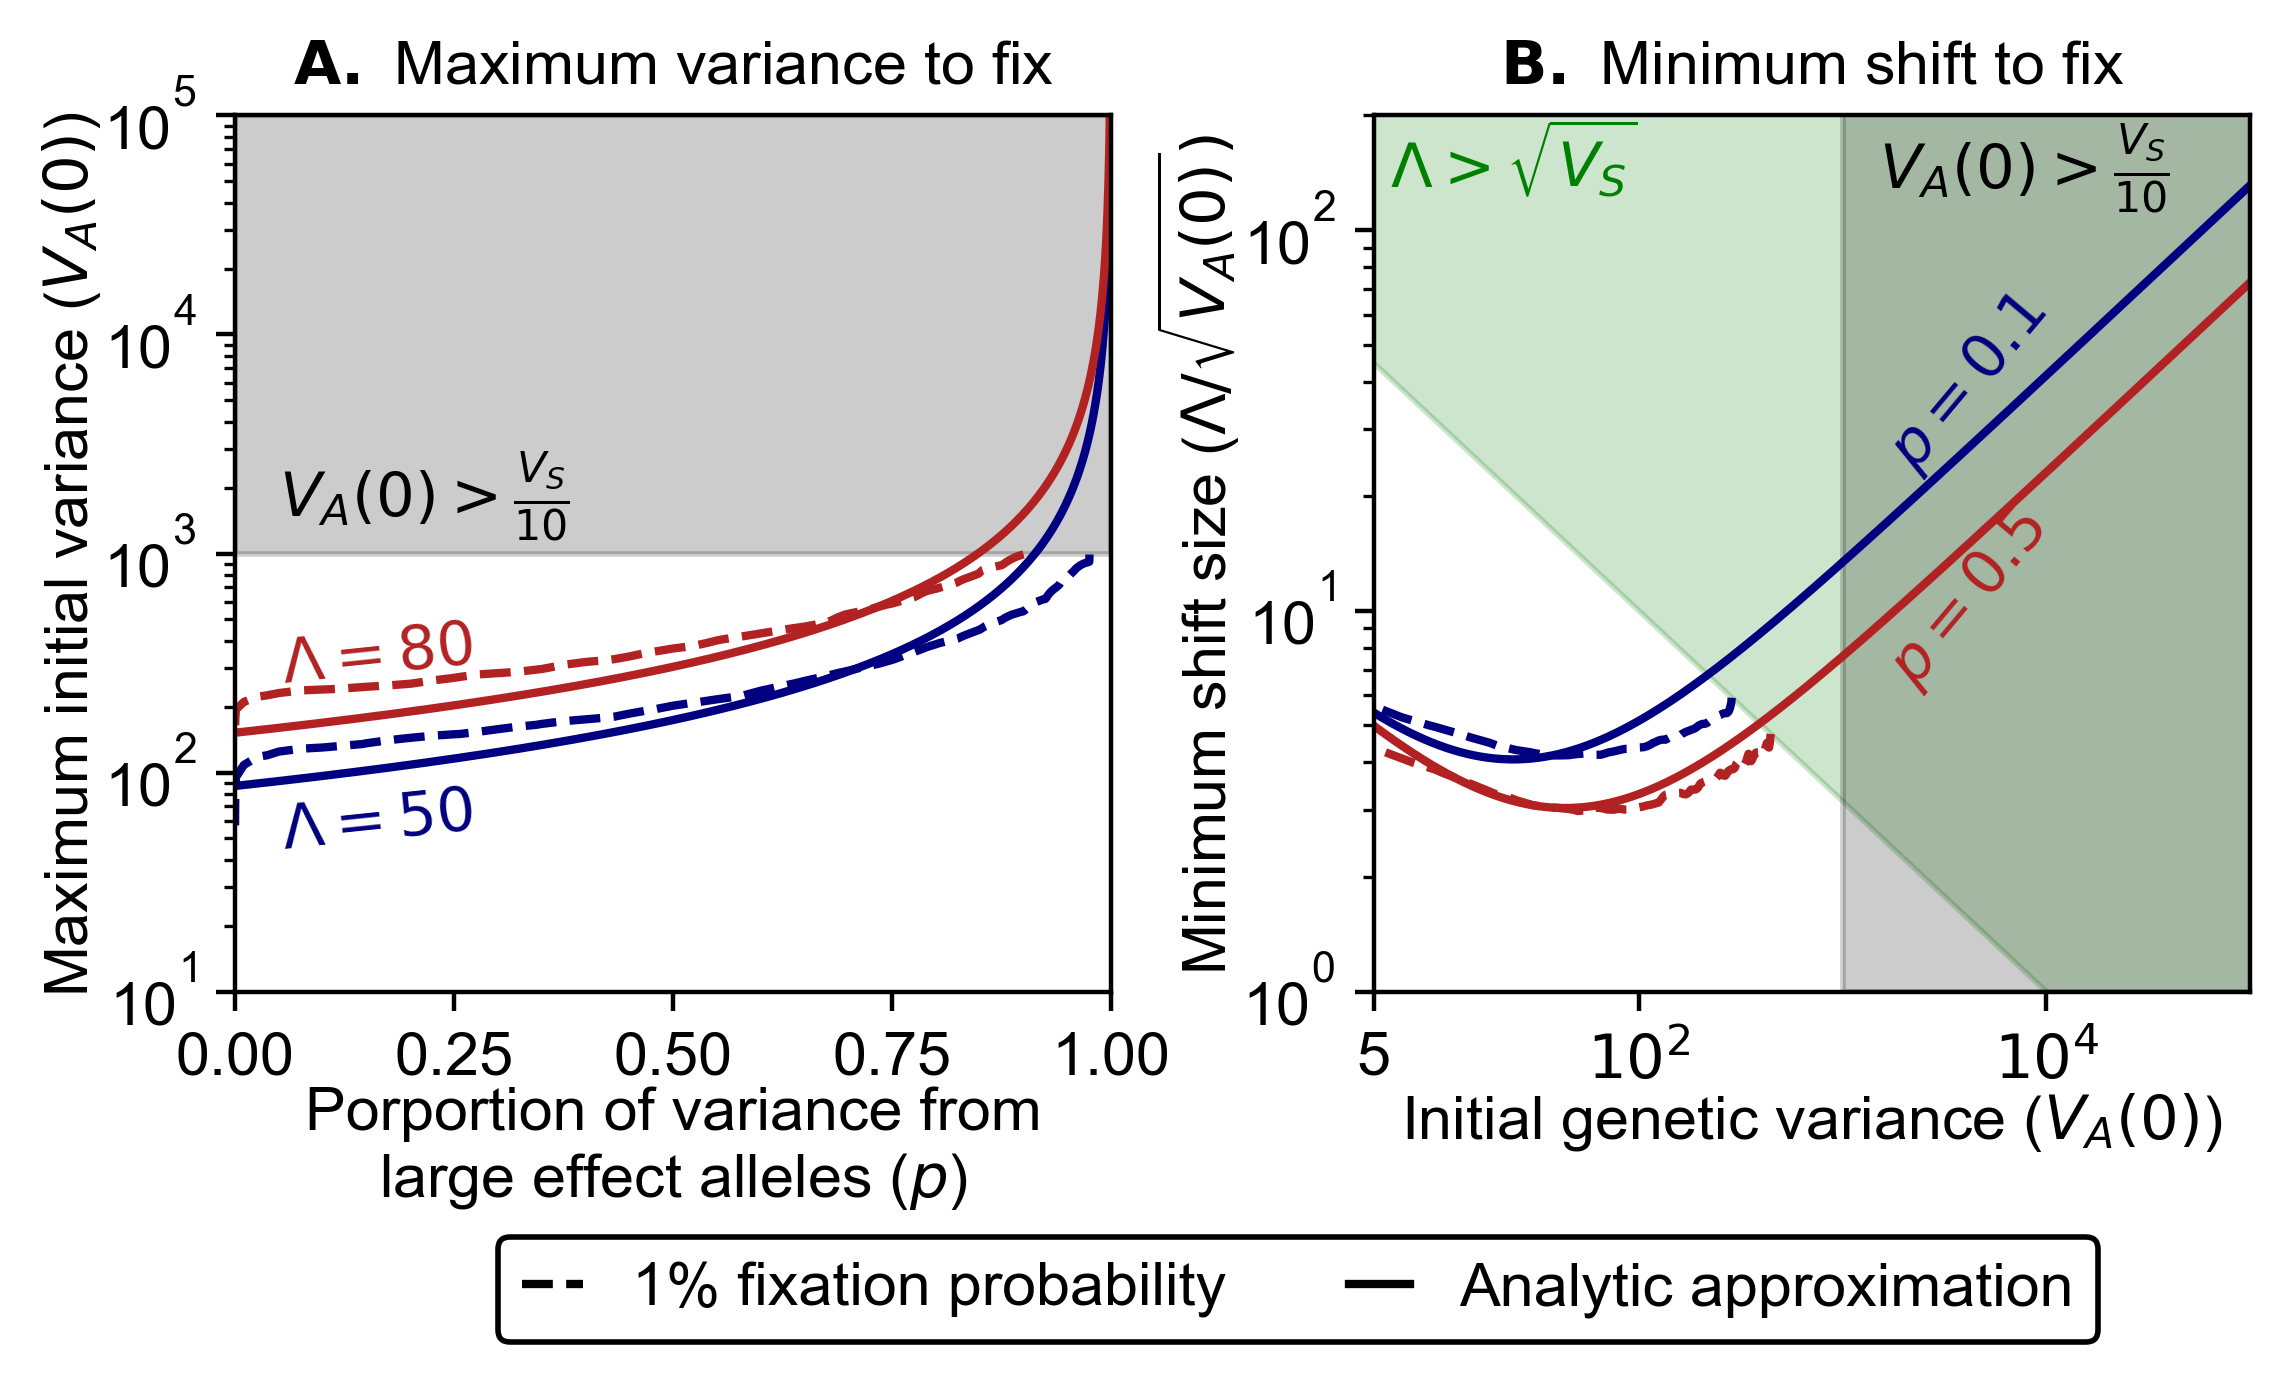

In [15]:
def min_shift(Va,p,a2):
    a = np.sqrt(a2)
    shift_std = (np.log(a2)/a)*(1-p)*np.sqrt(Va)+a/(np.sqrt(Va))
    return shift_std

def max_variance(shift,p,a2):
    a = np.sqrt(a2)
    var = a*(shift-a)/(np.log(a2)*(1-p))
    return var

def fig_6d_extended(ax,a2=100,p_values = [0.1,0.5],fontsize=11):
    
    var_values = np.logspace(0,5,1000)
    for p,color in zip(p_values,['navy','firebrick']):
        min_shift_values = np.array([min_shift(Va=Va,p=p,a2=a2) for Va in var_values])
        ax.plot(var_values,min_shift_values,color=color)
    ax.fill_between(var_values,100/np.sqrt(var_values),[500]*len(var_values),alpha=0.2,color='green')
    ax.fill_between([1000,1e6],[1,1],[500,500],color='k',alpha=0.2)
    ax.text(x=6,y=130,s=r'$\Lambda > \sqrt{V_S}$',color='green',fontsize=fontsize)
    ax.text(x=1500,y=24,s=r'$p=0.1$',color='navy',fontsize=fontsize,rotation=50)
    ax.text(x=1500,y=6.5,s=r'$p=0.5$',color='firebrick',fontsize=fontsize,rotation=50)
    ax.text(x=1500,y=130,s=r'$V_A(0)> \frac{V_S}{10}$',color='k',fontsize=fontsize)
    ax.set_title(r'$\bf{B.}$ Minimum shift to fix')
    ax.set_xlabel(r'Initial genetic variance ($V_A(0)$)',fontsize=fontsize,labelpad=0)
    ax.set_ylabel(r'Minimum shift size ($\Lambda/\sqrt{V_A(0)})$',fontsize=fontsize,labelpad=0)
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xlim([5,1e5])
    ax.set_xticks([5,100,10000])
    ax.set_xticklabels(['5',r'$10^2$',r'$10^4$'],fontsize=fontsize)
    ax.set_ylim([1,200])

    
def fig_6c_extended(ax,a2=100,shift_values = [50,80],fontsize=11):
    
    p_values = np.linspace(0,1,1000)
    p_values[-1] = 0.999
    for shift,color in zip(shift_values,['navy','firebrick']):
        max_var_values = np.array([max_variance(shift=shift,p=p,a2=a2) for p in p_values])
        ax.plot(p_values,max_var_values,color=color)

    ax.set_title(r'$\bf{A.}$ Maximum variance to fix',fontsize=fontsize)
    ax.set_xlabel('Porportion of variance from\n'+r'large effect alleles ($p$)',fontsize=fontsize,labelpad=0)
    ax.text(x=0.05,y = 260, s = '$\Lambda=80$',color='firebrick',rotation=6)
    ax.text(x=0.05,y = 45, s = '$\Lambda=50$',color='navy',rotation=6)
    ax.set_ylabel(r'Maximum initial variance (${V_A(0)}$)',fontsize=fontsize,labelpad=0)
    ax.set_yscale('log')
    ax.set_xlim([0,1])
    ax.set_ylim([10,1e5])
    
    ax.fill_between([0,1],[1000,1000],[1e5,1e5],color='k',alpha=0.2)
    ax.text(x = 0.05,y=1500,s=r'$V_A(0)> \frac{V_S}{10}$',color='k',fontsize=fontsize)
    

def create_figure_(height):
    fontsize = 11
    fig,axes = plt.subplots(ncols = 2, figsize = (6.5,height), dpi = 400)
    fig_6c_extended(ax=axes[0])
    fig_6d_extended(ax=axes[1])

    from copy import deepcopy as dc

    with open('/Users/will_milligan/PycharmProjects/Laura/Final_Figures/Phase_space_contour_lines.pickle','rb') as fin:
        contour_lines = pickle.load(fin)

    cmap = mpl.cm.get_cmap('Greys')
    for mode in ['fixations']:
        for raw in [False]:
            for name,color in zip(['alt','default'],['navy','firebrick']):
                for ax,key in zip([axes[0],axes[1]],['C','D']):
    
                        x,y,z = contour_lines[mode][raw][name][key]
                        
                        line = ax.contour(x,y,z, [0.01], colors=[[1,1,1,0]], linewidths=2,linestyles='--')
                        line = line.collections[0].get_paths()[0].vertices

                        x = line[:,0]
                        y = line[:,1]
                        
                        x_good = []
                        y_good = []
                        if key == 'C':
                            def pass_function(xx,yy):
                                return yy < 1000
                        else:
                            def pass_function(xx,yy):
                                if xx > 5:
                                    return yy < 100/np.sqrt(xx)
                                else:
                                    return False
                            
                        for xx,yy in zip(x,y):
                            if pass_function(xx,yy):
                                x_good.append(xx)
                                y_good.append(yy)
                        ax.plot(x_good,y_good,color=color,ls='--')
                    
                        
    axes[0].plot([],[],color='k',ls='--',label='1% fixation probability')
    axes[0].plot([],[],color='k',ls='-',label='Analytic approximation')
    axes[0].legend(framealpha=1,edgecolor='k',handlelength=1,fontsize=fontsize,loc=(0.3,-0.4),ncol=2)
    plt.subplots_adjust(wspace=0.3)
    # plt.tight_layout()
    
    bbox = ax.get_window_extent()

    # Convert the bounding box to inches using the figure's DPI
    width_inches = bbox.width / fig.dpi
    height_inches = bbox.height / fig.dpi
    print(width_inches,height_inches,height)
    if not np.isclose(width_inches,height_inches,rtol=0.01):
        
        height_inches = height*width_inches/height_inches
        return False,height_inches,fig
    else:
        return True,height_inches,fig

square = False
height_inches = 2.5
while not square:
    square,height_inches,fig = create_figure_(height=height_inches)
    if not square:
        plt.close()
    else:
        plt.savefig('./Figure_S13.png',dpi=300,bbox_inches='tight')



In [12]:
fadssdf

def variance_star(S,x):
    return 2*S*x*(1-x)
    
def establishment_prob(S,shift,x,sign=1):
    a = np.sqrt(S)*sign
    Sx = lambda x: a*(shift-a*(1/2-x))/(2*N)
#     if Sx(x) < 0: return 0
    establishment_prob_l = lambda x: (1 - np.exp(-4*N*Sx(x)*x))/(1 - np.exp(-4*N*Sx(x)))
    return establishment_prob_l(x)

def folded_sojourn_time(S,x,N=5000):
    if x < 0:
        raise ValueError
    elif x > 1/2:
        raise ValueError
    else:
        value = 2 * np.exp(-variance_star(S=S,x=x)/2) / (x * (1 - x))
        if x <= 1/(2*N):
            return 2 * N * x * value
        else:
            return value
        
            
class Mutation:
    def __init__(self,a2,x,sign,N):
        self.a2 = a2
        self.sign = sign
        self.x0 = x
        self.x = x
        self.N = N
        self.Vs = 2*N
        self.a = self.a2**(0.5)*sign
    
    def expected_change(self,D):
        return self.a/self.Vs*(D-self.a*(1/2-self.x))*self.x*(1-self.x)
    
    def realized_change(self,D):
        ec = self.expected_change(D)
        new_x = np.random.binomial(self.N*2,self.x+ec)/(2*self.N)
        rc = new_x - self.x
        self.x = new_x
        return rc*self.a*2
    
    def fixed(self):
        return self.x >= 1
    
    def loss(self):
        return self.x <= 0
    
    
def rooting_function(S,N,z,b,y):
 
    if z > 0 and z < 1/2:
        return quad(lambda x: folded_sojourn_time(S=S,x=x,N=N),0,z,points=[1/(2*N)])[0]/b-y
    elif z < 0:
        return z
    else:
        return -z

class Population:
    def __init__(self,N,shift,sigma2,sdist,N2U):
        self.sdist = sdist
        self.N = N
        self.Vs = 2*self.N
        self.shift = shift
        self.sigma2 = sigma2
        self.N2U = N2U
        self.mutations = []
        self.D = 0
        self.fixations = []
        self.t = 0
    
    def initialize_mutations(self):
        n_seg = quad(lambda S: self.sdist.pdf(S)*quad(lambda x: folded_sojourn_time(S=S,x=x,N=self.N),0,1/2,points=[1/(2*self.N)])[0],self.sdist.ppf(0.0001),self.sdist.ppf(0.9999))[0]
        for _ in range(np.random.poisson(n_seg)):
            S = self.sdist.rvs()
            b = quad(lambda x: folded_sojourn_time(S=S,x=x,N=self.N),0,1/2,points=[1/(2*self.N)])[0]
            y = np.random.random()
            x = root(lambda z: rooting_function(S=S,N=self.N,z=z,b=b,y=y),1/(2*self.N)).x[0]
            
            while x < 0 or x > 1/2:
                y = np.random.random()
                x = root(lambda z: rooting_function(S=S,N=self.N,z=z,b=b,y=y),1/(2*self.N)).x[0]
                
            sign_bit = np.random.random()
            if sign_bit < 0.5:
                sign = -1
            else:
                sign = 1
            self.mutations.append(Mutation(a2 = S, x = x, sign = sign, N = self.N))
    
    def shift_optimum(self):
        self.D = self.shift
        
    def next_gen(self):
        total_change = 0
        still_seg_mutations = []
        for m in self.mutations:
            total_change += m.realized_change(self.D)
            if m.fixed():
                self.fixations.append(m)
            elif m.loss():
                pass
            else:
                still_seg_mutations.append(m)
        self.mutations = still_seg_mutations
        total_change += self.D*self.sigma2/self.Vs
        self.D -= total_change
        
        for _ in range(np.random.poisson(self.N2U)):
            S = self.sdist.rvs()
            x = 1/(2*self.N)
            sign_bit = np.random.random()
            if sign_bit < 0.5:
                sign = -1
            else:
                sign = 1
            self.mutations.append(Mutation(a2 = S, x = x, sign = sign, N = self.N))
        
    def run_simulation(self):
        
        self.initialize_mutations()
        self.shift_optimum()
        while (np.abs(self.D) > 1 or self.t < 4*self.N):
            self.next_gen()
            self.t += 1
            if len(self.fixations)>0:
                break

sdist = stats.expon(loc=100,scale=400)
shift = 20
Va = np.array([1,2,5])
N = 5000
results = {}
for p in [0.1]:
    results[p] = {}
    sigma2 = Va*(1-p)
    N2U = Va*p/4
    for ss,nn in zip(sigma2,N2U):
        results[p][(ss,nn)] = {}
        for shift in [10,11,12]:
            results[p][(ss,nn)][shift] = []
            for _ in range(300):
                pops = Population(N=N,shift=shift,sigma2=ss,sdist=sdist,N2U=nn)
                pops.run_simulation()
                results[p][(ss,nn)][shift].append(pops.fixations)
            print(p,ss,nn,shift,len(results[p][(ss,nn)][shift]),len([x for x in results[p][(ss,nn)][shift] if len(x)>0]))
        
                
            
        
        
        


NameError: name 'fadssdf' is not defined

In [ ]:
cmap = mpl.cm.get_cmap('Greys')
var_set = set()
shift_use_set = set()
for N2U in results_D.keys():
    for sigma2 in results_D[N2U].keys():
        for shift in results_D[N2U][sigma2].keys():
            fixed, trials, adaptation = results_D[N2U][sigma2][shift]
            var = round(N2U*4+sigma2,5)
            var_set.add(var)
            shift_use = round(shift/np.sqrt(var),5)
            shift_use_set.add(shift_use)
            if trials > 0:
                plt.fill_between([max(0,var-2.5),var+2.5],[shift_use-0.125,shift_use-0.125],[shift_use+0.125,shift_use+0.125],color=cmap(fixed/trials),alpha=1)
print(np.sort(list(var_set)))
print(np.sort(list(shift_use_set)))


ValueError: too many values to unpack (expected 3)

In [ ]:
###OLD###
raise 


RuntimeError: No active exception to reraise

TypeError: 'set' object is not subscriptable

<Figure size 2000x2000 with 0 Axes>

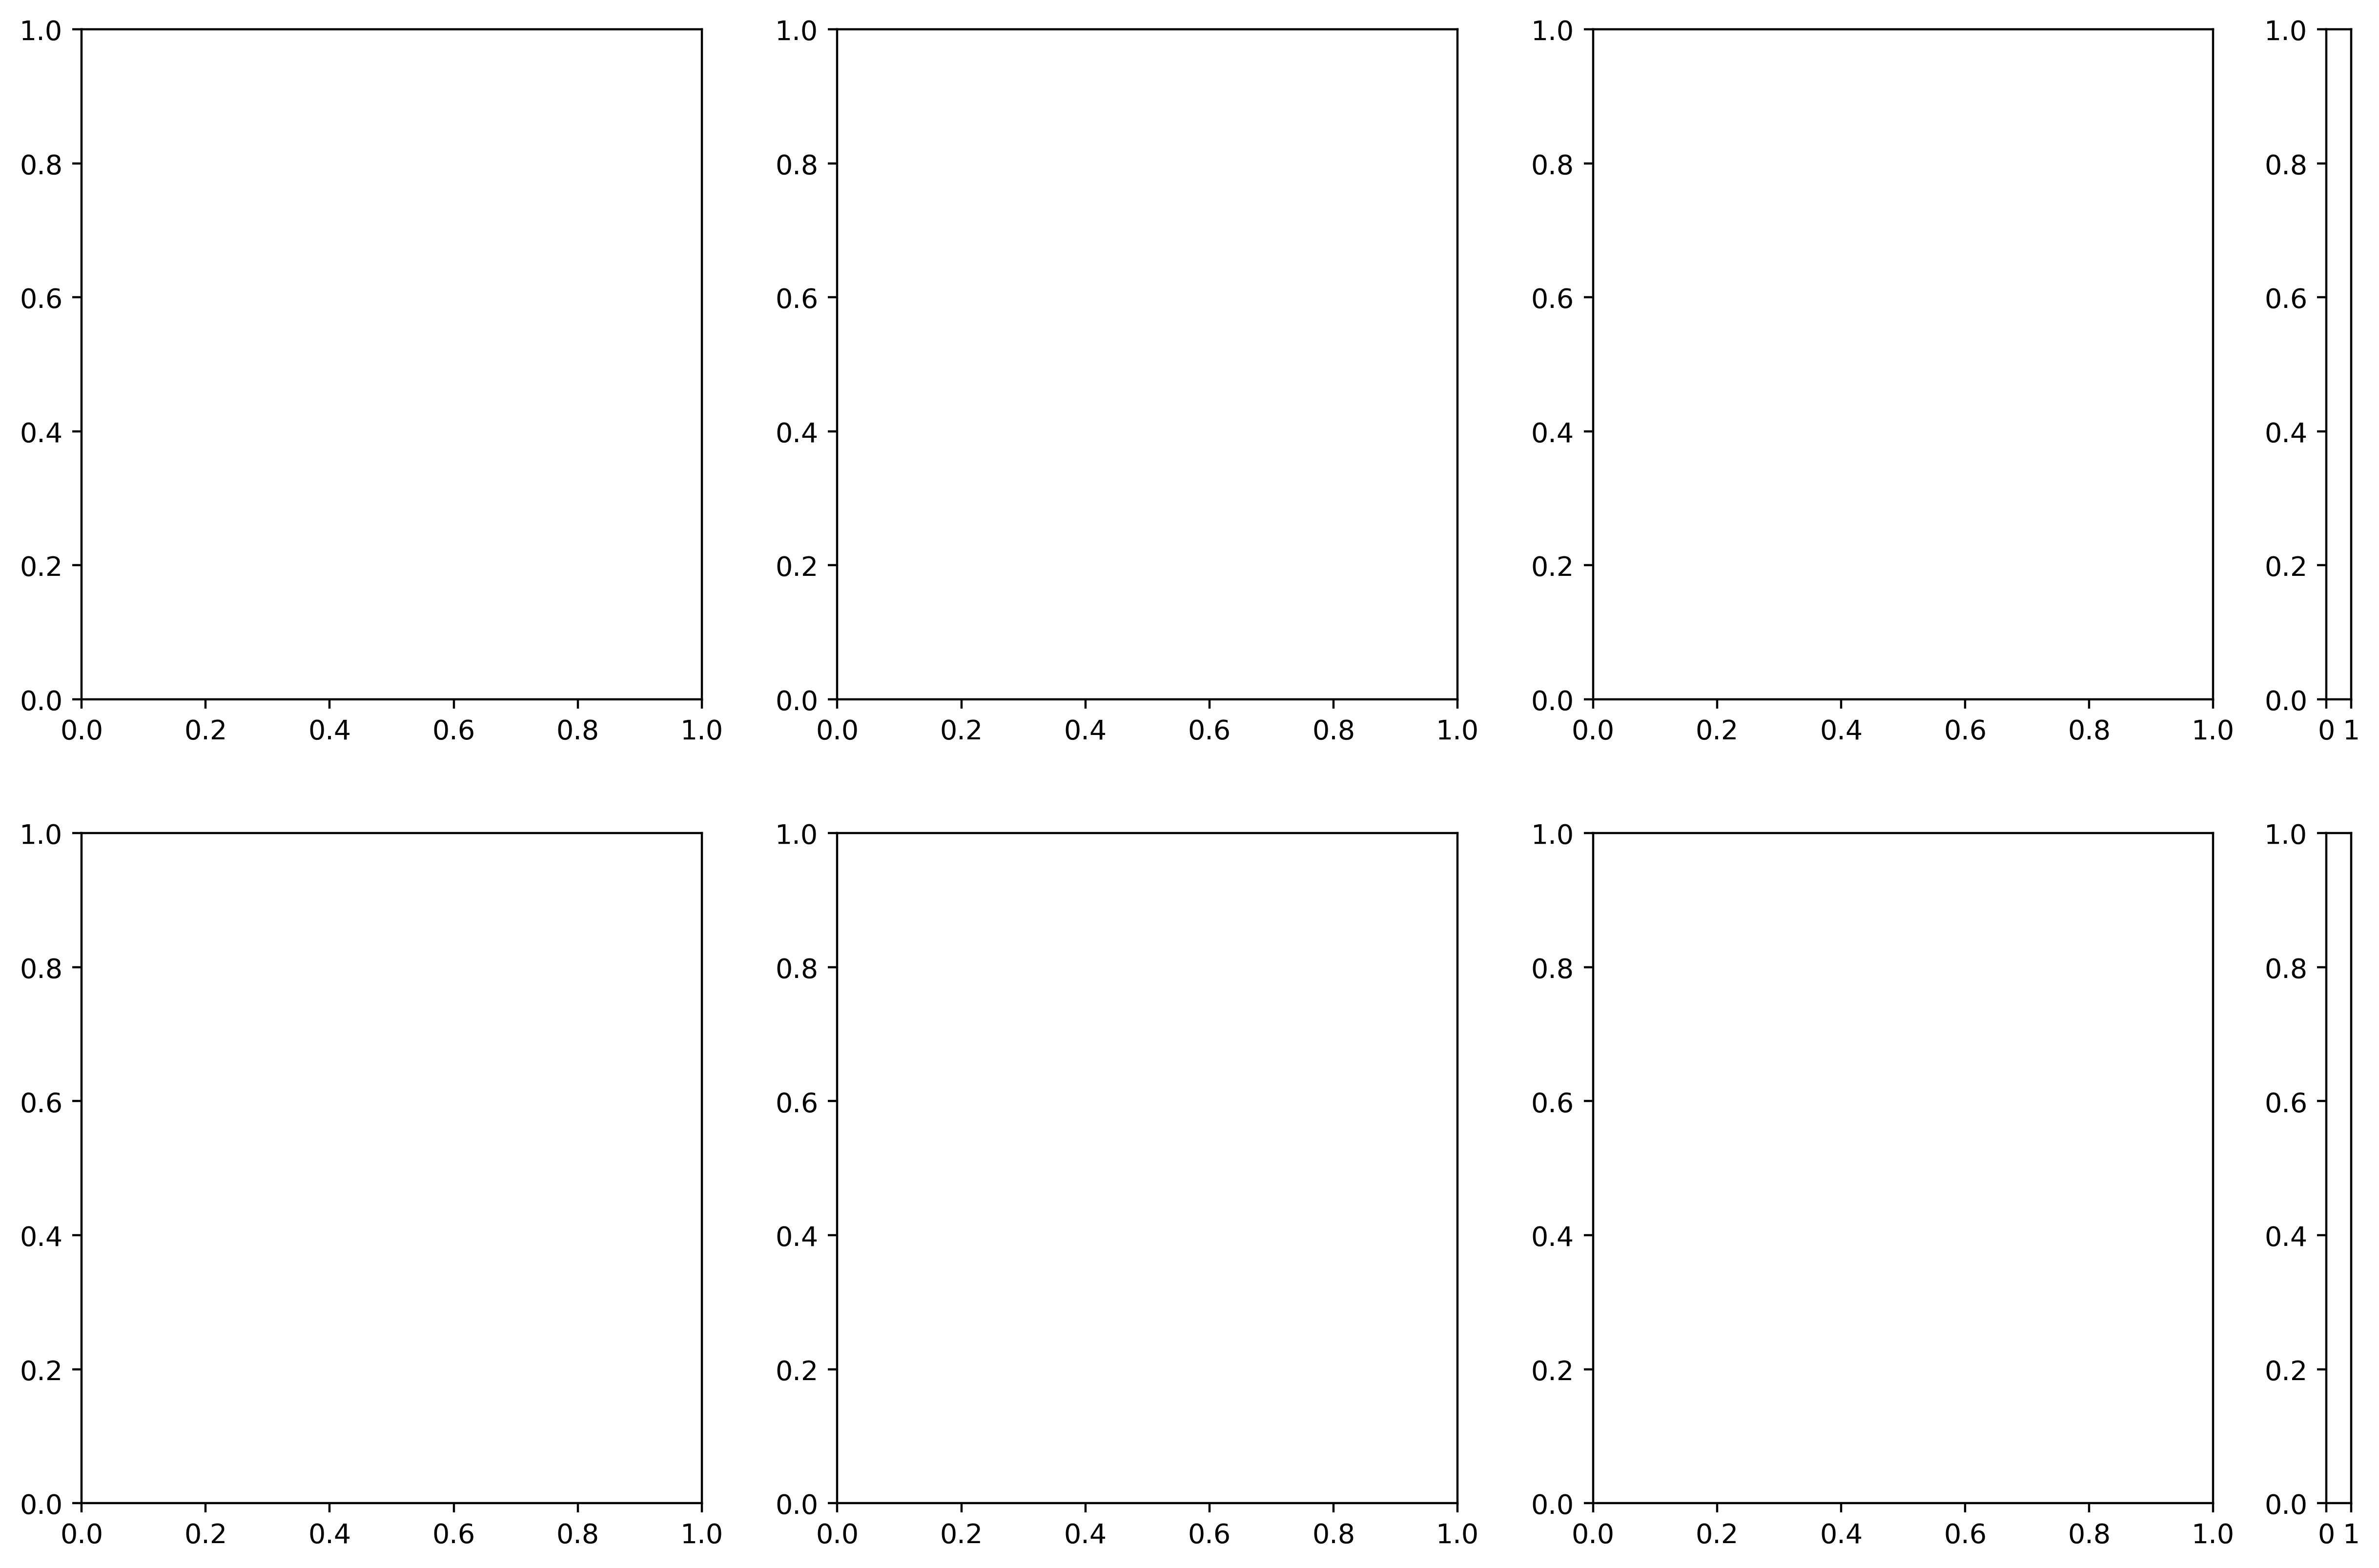

In [ ]:

# Create supplementary figure of raw heatmaps
fig = plt.figure(figsize=(5,5),dpi=400)
fig,axes_all = plt.subplots(nrows=2,ncols=7,figsize=(15,10),dpi=400,gridspec_kw={'width_ratios': [25,1,25,1,25,0.1,1]})
for axes in axes_all:
    for ax in axes[1::2]:
        ax.axis('off')


for axes,data,N2U_values_temp,unique_x_values_temp,label in zip(axes_all,[Y_all_results,Y_all_results_shift],[N2U_values,N2U_values_shift],[unique_x_values,unique_x_values_shift],['Shift','Sigma2']):
    for ax,key in zip(axes[::2],data.keys()):
        
        Y_all_here = np.transpose(data[key])
        logspacing_N2U = np.log10(N2U_values_temp[2])-np.log10(N2U_values_temp[1])
        N2U_values_here = (np.sort([10**(np.log10(i)-logspacing_N2U/2) for i in N2U_values_temp]+[2000]))*2
        print('here',N2U_values_here)
        x_value_spacing = unique_x_values_temp[2]-unique_x_values_temp[1]
        max_x = unique_x_values_temp[-1]
        unique_x_values_temp_temp = np.sort(list(unique_x_values_temp))-x_value_spacing/2
        unique_x_values_temp_temp[0] = 0
        unique_x_values_temp_temp[-1] = max_x
        # unique_x_values_temp = np.sort(list(unique_x_values_temp))
        
        
        unique_x_values_temp = np.sort(list(unique_x_values_temp))
        
        ax.pcolormesh(N2U_values_here,unique_x_values_temp,Y_all_here,cmap=cmap,norm=norm)
        ax.set_xscale('log')
        ax.set_xlim([1e-3,2e3])
        if label == 'Shift':
            ax.set_title('Shift = {}'.format(key))
            ax.set_ylabel(r'$\sigma^2$')
        else:
            ax.set_title(r'$\sigma^2 = $'+'{}'.format(key))
            ax.set_ylabel('Shift')
        ax.set_xlabel('N2U')
# Y_all_here = np.transpose(Y_all)
# N2U_values_here = (np.sort(list(N2U_values)))*2

# print(np.shape(Y_all),np.shape(list(N2U_values)),np.shape(unique_x_values))
# plt.pcolormesh(N2U_values_here,unique_x_values,Y_all_here,cmap=cmap,norm=norm)
# plt.xscale('log')
# plt.xlim([1e-3,1e3])
# print(N2U_values_here)
# norm=mpl.colors.LogNorm(vmin=1/100,vmax=1)
# plt.imshow((np.flip(np.transpose(np.flipud(Y_all)))),cmap=cmap,norm=norm)

### create a colorbar on axes[-1]
### include underflow color
### include a tickmark at 1/600 
for axes in axes_all:
    cbar = mpl.colorbar.ColorbarBase(axes[-1],cmap=cmap,norm=norm,orientation='vertical',extend='min')
    cbar.set_label('Fixation probability')
    # cbar.set_ticks([1/600,0.2,0.4,0.6,0.8,1])
    # cbar.set_ticklabels(["1/600",0.2,0.4,0.6,0.8,1])


In [ ]:
def sigma2_contour_plot(ax,results):
    N2U_values, unique_x_values,Y_all_results = process_results(results)
    plt.sca(ax)
    for shift,color in zip(np.sort(list(Y_all_results.keys())),['r','b','g']):
        
        Y_all = Y_all_results[shift]
        Z = (np.flip(np.transpose(np.flipud(Y_all))))
        # Z2 = Z
        Z2 = ndimage.gaussian_filter(np.flip(Z), sigma=[1.5,1], truncate = 1, order=0, mode = 'nearest')
        plt.contourf(2*np.sort(list(N2U_values)),np.sort(list(unique_x_values)),np.fliplr(Z2),[0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],cmap=cmap,alpha=1,algorithm='serial')
        
    plt.xscale('log')
    plt.ylabel(r'Background variance $\sigma^2$')
    plt.xlabel(r'Mutational input $2NU$')
    plt.ylim([0,250])

    plt.xlim([1e-3,1e3])            


In [ ]:
def find_closest_values_shift(sigma2,sigma2_dict,shift,mode='fixations'):

    if sigma2 in sigma2_dict.keys():
#         print(sigma2_dict[sigma2])
        if mode == 'fixations':
            return sigma2_dict[sigma2][0]
        else:
            return sigma2_dict[sigma2][-1]
    elif sigma2 > 300:
        return 0
    else:
        upper_sigma2 = 1000
        lower_sigma2 = 0
        for sigma2_key in sigma2_dict.keys():
            if np.isnan(sigma2_key):
                continue
            else:
                if sigma2_key > sigma2 and sigma2_key < upper_sigma2:
                    upper_sigma2 = sigma2_key
                if sigma2_key < sigma2 and sigma2_key > lower_sigma2:
                    lower_sigma2 = sigma2_key
#         print(sigma2_dict[lower_sigma2])
        if upper_sigma2 == 1000:
            if mode == 'fixations':
                return sigma2_dict[lower_sigma2][0]
            else:
                return sigma2_dict[lower_sigma2][-1]/shift
        elif lower_sigma2 == 0:
            if mode == 'fixations':
                return sigma2_dict[upper_sigma2][0]
            else:
                return sigma2_dict[upper_sigma2][-1]/shift
        else:
            if mode == 'fixations':
                return sigma2_dict[upper_sigma2][0]
            else:
                return sigma2_dict[upper_sigma2][-1]/shift
            
def process_results_shift(results):
    unique_x_values = set()
    N2U_values = set()
    for shift in results.keys():
        for N2U in results[shift].keys():
            N2U_values.add(N2U)
            x_temp = np.sort(list(results[shift][N2U].keys()))
            unique_x_values.update([x for x in x_temp if not np.isnan(x)])

    Y_all_results = {}
    for shift in results.keys():
        Y_all = []
        for N2U in np.sort(list(results[shift].keys())):
            y_temp = []
            for x in np.sort(list(unique_x_values)):
                if N2U > 450:
    #                 print(N2U)
                    y_temp.append(0)
                else:
                    y_temp.append(find_closest_values_shift(sigma2=x,sigma2_dict=results[shift][N2U],shift=shift))
    #             if N2U == 50:
    #                 print(find_closest_values_shift(sigma2=x,sigma2_dict=results_shift[shift][N2U],shift=shift)*600,x)
            Y_all.append(y_temp)
        Y_all_results[shift] = Y_all
    return N2U_values,unique_x_values, Y_all_results



In [ ]:
cmap.set_under('white')
cmap.set_over('green')
norm = mpl.colors.Normalize(vmin=0,vmax=80)


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("Greys").copy()
  """Entry point for launching an IPython kernel.
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("Greys").copy()
  


In [ ]:


def sigma2_contour_plot(ax,results):
    N2U_values, unique_x_values,Y_all_results = process_results(results)
    plt.sca(ax)
    for shift,color in zip(np.sort(list(Y_all_results.keys())),['r','b','g']):
        
        Y_all = Y_all_results[shift]
        Z = (np.flip(np.transpose(np.flipud(Y_all))))
        # Z2 = Z
        Z2 = ndimage.gaussian_filter(np.flip(Z), sigma=[1.5,1], truncate = 1, order=0, mode = 'nearest')
        # Z2[0:20,:7] = ndimage.gaussian_filter(np.flip(Z), sigma=[0,0.5], truncate=1, order=0,mode = 'constant',cval=0)[0:20,:7]

    #     plt.contourf(2*np.sort(list(N2U_values)),np.sort(list(unique_x_values)),np.fliplr(Z2),[46/600,74/600],colors=[color],alpha=0.5)
    #     plt.fill_between([],[],[],color=color,alpha=0.5,label=f'Shift = {shift}')
    #     plt.contour(2*np.sort(list(N2U_values)),np.sort(list(unique_x_values)),np.fliplr(Z2),[0.1])
        # plt.contourf(2*np.sort(list(N2U_values)),np.sort(list(unique_x_values)),np.fliplr(Z2),[0,1],colors=['b'],alpha=0.1)
        # plt.fill_between([1e-4,1e4],[225,225],[500,500],color='b',alpha=0.1,edgecolor='None')
        plt.contourf(2*np.sort(list(N2U_values)),np.sort(list(unique_x_values)),np.fliplr(Z2),[0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],cmap=cmap,alpha=1,algorithm='serial')
        # plt.contourf(2*np.sort(list(N2U_values)),np.sort(list(unique_x_values)),np.fliplr(Z2),[1,10,20,30,40,50,60,70,80,90,100],cmap=cmap,alpha=1,norm=norm)

    plt.xscale('log')
#     fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=plt.gca(),extend='min')
    # plt.legend()
    plt.ylabel(r'Background variance $\sigma^2$')
    plt.xlabel(r'Mutational input $2NU$')
    # plt.savefig('/Users/will_milligan/PycharmProjects/Laura/snakemake_figures/sdist_expon/N2U_fixations_contour_smoothed.png')



    shift = 80
    N2U_large = np.logspace(-3,3,100)
    y_min = []
    y_max = []
    for N2U in N2U_large:
        condition1 = (root(lambda sigma2: shift/(sigma2+4*N2U)**(0.5)-1/2*(sigma2/small_var_per_mutational_input+N2U)**(0.5),10).x[0])
        # Va << Vs
        condition2 = 0
        # - 4*N2U
        # trait is sufficiently polygenic
        condition3 = (100 - N2U)*small_var_per_mutational_input
        condition4 = 4*N2U
        y_min.append(max(condition1,max(condition2,max(condition4,condition3))))
    
    y_max = 1000-4*N2U_large
    ### find index where y_max < y_min
    index = np.where(y_max < y_min)[0][0]
    ### only plot the region where y_max < y_min
    # plt.fill_between(N2U_large[:index],y_min[:index],y_max[:index],color='b',alpha=0.1,edgecolor='None')
    # plt.fill_between(N2U_large,y_min,y_max,color='b',alpha=0.1,edgecolor='None')
    plt.ylim([0,250])
    # plt.text(x=1e-3*1.2,y=240,s='Highly polygenic adaptation',color='b')
    # plt.text(x=1e-3*1.2,y=220,s='(Hayward & Sella 2022)',color='b')
    # plt.text(x=500,y=125,s=r'$V(a|a^2 \geq 100)>\sigma^2$',color='r',rotation=90,va='center')

    def establishment_prob(S,shift,x,sign=1):
        a = np.sqrt(S)*sign
        Sx = lambda x: a*(shift-a*(1/2-x))/(2*N)
    #     if Sx(x) < 0: return 0
        establishment_prob_l = lambda x: (1 - np.exp(-4*N*Sx(x)*x))/(1 - np.exp(-4*N*Sx(x)))
        return establishment_prob_l(x)

    ss = lambda S: (np.sqrt(S)/(2*N)*(shift-np.sqrt(S)/2))
    pe = quad(lambda S: stats.expon(scale=400,loc=100).pdf(S)*establishment_prob(S=S,shift=shift,x=1/(2*N)),100,np.infty)[0]
    s0 = quad(lambda S: stats.expon(scale=400,loc=100).pdf(S)*4*(np.log(ss(S)*2*N)+0.5)/ss(S),100,10000)[0]
    print(pe,s0,1/(2*s0))

    N2U_large = np.logspace(-3,np.log10(0.002),100)#np.log10(1/(2*s0)),100)
    right = 1/(N2U_large)+2*s0
    sigma2 = 2*N/(10*right)
    print(sigma2)
    sigma2 = [max(2,s) for s in sigma2]
    # plt.fill_between(N2U_large,sigma2,[0]*len(N2U_large),color='darkorange',alpha=1,edgecolor='None')
    # plt.text(x=0.1,y=2.5,s='Adaptive walks',color='darkorange')
    # plt.arrow(x=0.089,y=5,dx=-0.0855,dy=0,head_width=3,head_length=0.001,color='darkorange')
    plt.xlim([1e-3,1e3])
# plt.yscale('log')
# plt.ylim([1e-5,100])
            

In [ ]:
def find_closest_values_shift(sigma2,sigma2_dict,shift,mode='fixations'):

    if sigma2 in sigma2_dict.keys():
#         print(sigma2_dict[sigma2])
        if mode == 'fixations':
            return sigma2_dict[sigma2][0]
        else:
            return sigma2_dict[sigma2][-1]
    elif sigma2 > 300:
        return 0
    else:
        upper_sigma2 = 1000
        lower_sigma2 = 0
        for sigma2_key in sigma2_dict.keys():
            if np.isnan(sigma2_key):
                continue
            else:
                if sigma2_key > sigma2 and sigma2_key < upper_sigma2:
                    upper_sigma2 = sigma2_key
                if sigma2_key < sigma2 and sigma2_key > lower_sigma2:
                    lower_sigma2 = sigma2_key
#         print(sigma2_dict[lower_sigma2])
        if upper_sigma2 == 1000:
            if mode == 'fixations':
                return sigma2_dict[lower_sigma2][0]
            else:
                return sigma2_dict[lower_sigma2][-1]/shift
        elif lower_sigma2 == 0:
            if mode == 'fixations':
                return sigma2_dict[upper_sigma2][0]
            else:
                return sigma2_dict[upper_sigma2][-1]/shift
        else:
            if mode == 'fixations':
                return sigma2_dict[upper_sigma2][0]
            else:
                return sigma2_dict[upper_sigma2][-1]/shift
            
def process_results_shift(results):
    unique_x_values = set()
    N2U_values = set()
    for shift in results.keys():
        for N2U in results[shift].keys():
            N2U_values.add(N2U)
            x_temp = np.sort(list(results[shift][N2U].keys()))
            unique_x_values.update([x for x in x_temp if not np.isnan(x)])

    Y_all_results = {}
    for shift in results.keys():
        Y_all = []
        for N2U in np.sort(list(results[shift].keys())):
            y_temp = []
            for x in np.sort(list(unique_x_values)):
                if N2U > 450:
    #                 print(N2U)
                    y_temp.append(0)
                else:
                    y_temp.append(find_closest_values_shift(sigma2=x,sigma2_dict=results[shift][N2U],shift=shift))
    #             if N2U == 50:
    #                 print(find_closest_values_shift(sigma2=x,sigma2_dict=results_shift[shift][N2U],shift=shift)*600,x)
            Y_all.append(y_temp)
        Y_all_results[shift] = Y_all
    return N2U_values,unique_x_values, Y_all_results

# with open('/Users/will_milligan/PycharmProjects/Laura/snakemake_figures/sdist_expon/N2U_fixations_contour_shift_results.pickle','rb') as fin:
#     results_shift = pickle.load(fin)
    
# with open('/Users/will_milligan/Desktop/N2U_fixations_contour_shift_results.02052025.pickle','rb') as fin:
#     results_shift = pickle.load(fin)
    
# print(results_shift.keys())
# print(results_shift[80].keys())
# print(results_shift[80][50][100.0])


In [ ]:


def sigma2_contour_plot_single_contour_multiple_shifts(ax,results):
    cs_dict = {}
    N2U_values,unique_x_values,Y_all_results = process_results(results)
    plt.sca(ax)
    for shift,color,ls in zip(np.sort(list(Y_all_results.keys())),[[0.8,0.2,0.8],[0.5,0.5/0.8*0.2,0.5],[0.2,0.2/0.7*0.2,0.2]],['-.','--','-']):
#         print(shift)
        Y_all = Y_all_results[shift]
        Z = (np.flip(np.transpose(np.flipud(Y_all))))
        Z2 = ndimage.gaussian_filter(np.flip(Z), sigma=[1.5,1], order=0)
    #     plt.contourf(2*np.sort(list(N2U_values)),np.sort(list(unique_x_values)),np.fliplr(Z2),[46/600,74/600],colors=[color],alpha=0.5)
        plt.plot([],[],color=color,label=f'Shift = {shift}')
        cs_dict[shift] = (plt.contour(2*np.sort(list(N2U_values)),np.sort(list(unique_x_values)),np.fliplr(Z2),[0.1],colors=[color],linestyles=[ls]),color)
#         plt.contourf(2*np.sort(list(N2U_values)),np.sort(list(unique_x_values)),np.fliplr(Z2),[0,0.01],colors=['w'])
#         plt.contourf(2*np.sort(list(N2U_values)),np.sort(list(unique_x_values)),np.fliplr(Z2),[0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],cmap=cmap,alpha=1)

    plt.xscale('log')
#     fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=plt.gca(),extend='min')
    # plt.legend()
    plt.ylabel(r'Background variance $\sigma^2$')
    plt.xlabel(r'Mutational input $2NU$')
    
    N2U_large = np.logspace(-3,3,100)
    
    for shift,ls in zip([50,80,100],['-.','--','-']):
        N2U_large = np.logspace(-3,3,100)
        y_min = []
        y_max = []
        for N2U in N2U_large:
            condition1 = (root(lambda sigma2: shift/(sigma2+4*N2U)**(0.5)-1/2*(sigma2/small_var_per_mutational_input+N2U)**(0.5),10).x[0])
            # Va << Vs
            condition2 = 0
            # - 4*N2U
            # trait is sufficiently polygenic
            condition3 = (100 - N2U)*small_var_per_mutational_input
            condition4 = 4*N2U
            y_min.append(max(condition1,max(condition2,max(condition4,condition3))))
        
        y_max = 1000-4*N2U_large
        ### find index where y_max < y_min
        index = np.where(y_max < y_min)[0][0]
        ### only plot the region where y_max < y_min
        # plt.fill_between(N2U_large[:index],y_min[:index],y_max[:index],color='b',alpha=0.1,edgecolor='b',ls=ls,lw=2)
    # plt.fill_between(N2U_large,[0]*len(N2U_large),4*N2U_large,color='r',alpha=0.1,edgecolor='None')    
    plt.ylim([0,250])
#     plt.text(x=1e-3*1.2,y=240,s='Highly polygenic adaptation',color='b')

    def establishment_prob(S,shift,x,sign=1):
        a = np.sqrt(S)*sign
        Sx = lambda x: a*(shift-a*(1/2-x))/(2*N)
    #     if Sx(x) < 0: return 0
        establishment_prob_l = lambda x: (1 - np.exp(-4*N*Sx(x)*x))/(1 - np.exp(-4*N*Sx(x)))
        return establishment_prob_l(x)

    shift = 50
    ss = lambda S: (np.sqrt(S)/(2*N)*(shift-np.sqrt(S)/2))
    pe = quad(lambda S: stats.expon(scale=400,loc=100).pdf(S)*establishment_prob(S=S,shift=shift,x=1/(2*N)),100,np.infty)[0]
    s0 = quad(lambda S: stats.expon(scale=400,loc=100).pdf(S)*4*(np.log(ss(S)*2*N)+0.5)/ss(S),100,10000)[0]
#     print(pe,s0,1/(2*s0))

    
    N2U_large = np.logspace(-3,np.log10(0.002),100)#np.log10(1/(2*s0)),100)
    right = 1/(N2U_large)+2*s0
    sigma2 = 2*N/(10*right)
    sigma2 = [max(2,s) for s in sigma2]
    # plt.fill_between(N2U_large,sigma2,[0]*len(N2U_large),color='darkorange',alpha=1,edgecolor='None')
    
    for shift,(cs,color) in cs_dict.items():
        p1 = cs.collections[0].get_paths()[0]
        coor_p1 = p1.vertices
        
        xxx = [iii[0] for iii in coor_p1]
        yyy = [iii[1] for iii in coor_p1]
        
        ### sort x and y
        xxx = np.array(xxx)
        yyy = np.array(yyy)
        idx = np.argsort(xxx)
        xxx = xxx[idx]
        yyy = yyy[idx]
        
        yyy = [yy for xx,yy in zip(xxx,yyy) if xx > 1e-1]
        xxx = [xx for xx in xxx if xx > 1e-1]
        
        print('dumb',xxx,yyy)
        #adding the text
        text = CurvedText(
            x = xxx,
            y = yyy,
            text='Shift = '+str(shift),
            va = 'bottom',
            axes = ax,
            color=color)
        print(text)

        ##calls ax.add_artist in __init__
#     plt.text(x=0.1,y=2.5,s='Adaptive walks',color='r')
#     plt.arrow(x=0.089,y=5,dx=-0.0855,dy=0,head_width=3,head_length=0.001,color='r')
        
#         small_var_per_mutational_input = 1.488
#         N2U_large = np.logspace(-3,3,100)
#         y = []
#         for N2U in N2U_large:
#             condition1 = (root(lambda sigma2: shift/(sigma2+4*N2U)-1/2*(sigma2/small_var_per_mutational_input+N2U),10).x[0])
#             condition2 = 100 - 4*N2U
#             condition3 = (100 - N2U)*small_var_per_mutational_input
#             condition4 = 4*N2U
#             y.append(max(condition1,max(condition2,max(condition4,condition3))))
#         plt.fill_between(N2U_large,y,[1000]*len(N2U_large),color='k',alpha=0.1,edgecolor='None')
#         plt.ylim([0,250])
#         plt.text(x=1e-3*1.2,y=240,s='Highly polygenic adaptation',color='darkgrey')

#         def establishment_prob(S,shift,x,sign=1):
#             a = np.sqrt(S)*sign
#             Sx = lambda x: a*(shift-a*(1/2-x))/(2*N)
#         #     if Sx(x) < 0: return 0
#             establishment_prob_l = lambda x: (1 - np.exp(-4*N*Sx(x)*x))/(1 - np.exp(-4*N*Sx(x)))
#             return establishment_prob_l(x)

#         ss = lambda S: (np.sqrt(S)/(2*N)*(shift-np.sqrt(S)/2))
#         pe = quad(lambda S: stats.expon(scale=400,loc=100).pdf(S)*establishment_prob(S=S,shift=shift,x=1/(2*N)),100,np.infty)[0]
#         s0 = quad(lambda S: stats.expon(scale=400,loc=100).pdf(S)*4*(np.log(ss(S)*2*N)+0.5)/ss(S),100,10000)[0]
#         print(pe,s0,1/(2*s0))

#         N2U_large = np.logspace(-3,np.log10(1/(2*s0)),100)
#         right = 1/(N2U_large)+2*s0
#         sigma2 = 2*N/(10*right)
# #         print(sigma2)
# #         sigma2 = [max(2,s) for s in sigma2]
#         plt.fill_between(N2U_large,sigma2,[0]*len(N2U_large),color='r',alpha=1,edgecolor='None')
#         plt.text(x=0.1,y=2.5,s='Adaptive walks',color='r')
#         plt.arrow(x=0.089,y=5,dx=-0.0855,dy=0,head_width=3,head_length=0.001,color='r')
# plt.yscale('log')
# plt.ylim([1e-5,100])
            

In [ ]:

def shift_contour_plot(ax,results):
    N2U_values_shift, unique_x_values_shift, Y_all_results_shift = process_results_shift(results)
    plt.sca(ax)
    for shift,color in zip(np.sort(list(Y_all_results_shift.keys())),[[0.8,0.2,0.8],[0.5,0.5/0.8*0.2,0.5],[0.2,0.2/0.7*0.2,0.2]]):
        if shift != 40: continue
        Y_all = Y_all_results_shift[shift]
        Z = (np.flip(np.transpose(np.flipud(Y_all))))
        Z2 = ndimage.gaussian_filter(np.flip(Z), sigma=[1.5,1], order=0)
        # plt.contourf(2*np.sort(list(N2U_values_shift)),np.sort(list(unique_x_values_shift)),np.fliplr(Z2),[0,1],colors=['white'],alpha=1)
        plt.contourf(2*np.sort(list(N2U_values_shift)),np.sort(list(unique_x_values_shift)),np.fliplr(Z2),[0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],cmap=cmap,alpha=1)
        # plt.contourf(2*np.sort(list(N2U_values_shift)),np.sort(list(unique_x_values_shift)),np.fliplr(Z2),[1,10,20,30,40,50,60,70,80,90,100],cmap=cmap,alpha=1,norm=norm)
        plt.contourf(2*np.sort(list(N2U_values_shift)),np.sort(list(unique_x_values_shift)),np.fliplr(Z2),[0,0.01],colors=['white'],alpha=1)

    plt.xscale('log')

    sdist = stats.expon(scale=400,loc=100)
    sdist_small = stats.expon(scale=1,loc=0)
    sdist_nonlande = stats.expon(scale=16,loc=0)
    def variance_star(S,x):
        return 2*S*x*(1-x)

    def folded_sojourn_time(S,x,N=5000):
        if x < 0:
            raise ValueError
        elif x > 1/2:
            raise ValueError
        else:
            value = 2 * np.exp(-variance_star(S=S,x=x)/2) / (x * (1 - x))
            if x <= 1/(2*N):
                return 2 * N * x * value
            else:
                return value
            

    # N2U_small = 80/small_var_per_mutational_input
    # N2U_large = np.logspace(-3,3,1000)
    # N2U_large_real = []
    # sigma2 = 80
    # for N2U in N2U_large:
    #     # Va << Vs
    #     if N2U > 1000 - sigma2:
    #         continue
    #     elif N2U + N2U_small < 100:
    #         continue
    #     elif 4*N2U > sigma2:
    #         continue
    #     else:
    #         N2U_large_real.append(N2U)
    # N2U_large_real = np.array(N2U_large_real)
    # print(N2U_large_real)
    # laura_lambda = 1/2*np.sqrt(N2U_small+N2U_large_real)*np.sqrt(small_var_per_mutational_input*N2U_small+4*N2U_large_real)
    # print('lauraa',laura_lambda)
    # plt.fill_between(N2U_large_real,laura_lambda,[0]*len(N2U_large_real),color='b',alpha=0.1,edgecolor='None')
    # plt.fill_between([80/4,1000],[0,0],[1000,1000],color='r',alpha=0.1,edgecolor='None')
    plt.ylim([0,100])
    
    
    
    
        #     small_var_per_mutational_input = 1.488
        # N2U_large = np.logspace(-3,3,100)
        # y_min = []
        # y_max = []
        # for N2U in N2U_large:
        #     condition1 = (root(lambda sigma2: shift/(sigma2+4*N2U)**(0.5)-1/2*(sigma2/small_var_per_mutational_input+N2U)**(0.5),10).x[0])
        #     # Va << Vs
        #     condition2 = 0
        #     # - 4*N2U
        #     # trait is sufficiently polygenic
        #     condition3 = (100 - N2U)*small_var_per_mutational_input
        #     condition4 = 4*N2U
        #     y_min.append(max(condition1,max(condition2,max(condition4,condition3))))
        
        # y_max = 1000-4*N2U_large
        # ### find index where y_max < y_min
        # index = np.where(y_max < y_min)[0][0

    plt.ylabel(r'Shift size $\Lambda$')
    plt.xlabel(r'Mutational input $2NU$')



In [ ]:


def shift_contour_plot_multiple_sigma2(ax,results):
    N2U_values,unique_x_values, Y_all_results_shift = process_results_shift(results)
    plt.sca(ax)
    cs_dict = {}
    for shift,color,ls in zip(np.sort(list(Y_all_results_shift.keys())),[[0.8,0.2,0.8],[0.5,0.5/0.8*0.2,0.5],[0.2,0.2/0.8*0.2,0.2]],['-.','--','-']):
        print(shift)
        Y_all = Y_all_results_shift[shift]
        Z = (np.flip(np.transpose(np.flipud(Y_all))))
        Z2 = ndimage.gaussian_filter(np.flip(Z), sigma=[1.5,1], order=0)
    #     plt.contourf(2*np.sort(list(N2U_values)),np.sort(list(unique_x_values)),np.fliplr(Z2),[46/600,74/600],colors=[color],alpha=0.5)
        # plt.plot([],[],[],color=color,alpha=1,label=f'sigma2 = {shift}')
        cs_dict[shift] = (plt.contour(2*np.sort(list(N2U_values)),np.sort(list(unique_x_values)),np.fliplr(Z2),[0.1],colors=[color],linestyles=[ls]),color)
    #         plt.contourf(2*np.sort(list(N2U_values_shift)),np.sort(list(unique_x_values_shift)),np.fliplr(Z2),[0,0.01],colors=['w'])
    #         plt.contourf(2*np.sort(list(N2U_values_shift)),np.sort(list(unique_x_values_shift)),np.fliplr(Z2),[0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],cmap=cmap,alpha=1)

    plt.xscale('log')

    sdist = stats.expon(scale=400,loc=100)
    sdist_small = stats.expon(scale=1,loc=0)
    sdist_nonlande = stats.expon(scale=16,loc=0)
    def variance_star(S,x):
        return 2*S*x*(1-x)

    def folded_sojourn_time(S,x,N=5000):
        if x < 0:
            raise ValueError
        elif x > 1/2:
            raise ValueError
        else:
            value = 2 * np.exp(-variance_star(S=S,x=x)/2) / (x * (1 - x))
            if x <= 1/(2*N):
                return 2 * N * x * value
            else:
                return value
            
    
    for sigma2_temp,ls in zip([40,80,120],['-.','--','-']):
        N2U_small = 80/small_var_per_mutational_input
        N2U_large = np.logspace(-3,3,1000)
        N2U_large_real = []
        
        for N2U in N2U_large:
            # Va << Vs
            if N2U > 1000 - sigma2_temp:
                continue
            elif N2U + N2U_small < 100:
                continue
            elif 4*N2U > sigma2_temp:
                continue
            else:
                N2U_large_real.append(N2U)
        N2U_large_real = np.array(N2U_large_real)
        
        laura_lambda = 1/2*np.sqrt(N2U_small+N2U_large_real)*np.sqrt(small_var_per_mutational_input*N2U_small+4*N2U_large_real)
        
        # plt.fill_between(N2U_large_real,laura_lambda,[0]*len(N2U_large_real),color='b',alpha=0.1,edgecolor='None')
        # plt.fill_between([sigma2_temp/4,1000],[0,0],[1000,1000],color='r',alpha=0.1,edgecolor='r',ls=ls,lw=2)
        
    plt.ylim([0,100])
    for shift,(cs,color) in cs_dict.items():
        p1 = cs.collections[0].get_paths()[0]
        coor_p1 = p1.vertices
        
        xxx = [iii[0] for iii in coor_p1]
        yyy = [iii[1] for iii in coor_p1]
        
        ### sort x and y
        xxx = np.array(xxx)
        yyy = np.array(yyy)
        idx = np.argsort(xxx)
        xxx = xxx[idx]
        yyy = yyy[idx]
        
        yyy = [yy for xx,yy in zip(xxx,yyy) if xx > 1e-1]
        xxx = [xx for xx in xxx if xx > 1e-1]
        
        # find the index of the value in xxx that is closest to 2
        index = np.argmin(np.abs(np.array(xxx)-2))
        y_use = yyy[index]-5
        curve = [np.logspace(np.log10(2/4),np.log10(2*4),100),np.array([y_use]*100)]
        
        # add text to matplotlib figure in data coordinates
        plt.text(x=2,y=y_use,s=r'$\sigma^2 =$ '+str(shift),color=color,ha='center',va='center')
        
    plt.ylim([0,100])

    plt.ylabel(r'Shift size $\Lambda$')
    plt.xlabel(r'Mutational input $2NU$')
    
    # plt.legend()


In [ ]:
import gzip

def plot_figure_6_d(ax,ax_cbar):
    # extract all colors from the .jet map
    cmap = mpl.cm.get_cmap('Greys')
    cmaplist = [cmap(i) for i in range(cmap.N)]

    # create the new map
    cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'Custom cmap', cmaplist, cmap.N)

    # define the bins and normalize
    bounds = [0,0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

    p = 0.5
    if p == 0.5:
        with open('/Users/will_milligan/Desktop/Sella/alt_parameters_concat_over_shift_values.pickle.gz','rb') as f:
            results_z = pickle.load(f)
    else:
        with open('/Users/will_milligan/Desktop/Sella/p_'+str(p)+'_alt_parameters_concat_over_shift_values.pickle.gz','rb') as f:
            results_z = pickle.load(f)
    # {N2U:sigma2:shift}
    storage_z = []
    fig, (axt,ax_cbart)= plt.subplots(ncols=2,dpi=400,figsize=(4,4),gridspec_kw={'width_ratios':[10,0.5]})
    plt.sca(axt)
    Va_values = []
    temp = list(results_z[0.125].keys())[0]
    shift_values = np.sort(list(results_z[0.125][temp].keys()))
    even_matrix = np.zeros((len(results_z),len(shift_values)))
    for i,N2U in enumerate(np.sort(list(results_z.keys()))):
        for sigma2 in results_z[N2U].keys():
            Va = 4*N2U+sigma2
            Va_values.append(Va)
            for j,shift in enumerate(np.sort(list(results_z[N2U][sigma2].keys()))):
                p_fix = results_z[N2U][sigma2][shift][0]/results_z[N2U][sigma2][shift][1]
                even_matrix[i,j] = p_fix

    Z2 = ndimage.gaussian_filter(even_matrix, sigma=[1,1], order=0)
    cs = plt.contour(Va_values,shift_values,np.transpose(Z2),levels=[0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],cmap='Greys')
    paths = cs.collections
    plt.close()

    # fig, (ax,ax_cbar)= plt.subplots(ncols=2,dpi=400,figsize=(4,4),gridspec_kw={'width_ratios':[10,0.5]})
    for ii,(path,color_i) in enumerate(zip(paths,[0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])):
        try:
            ppath = path.get_paths()[0].vertices
            x = ppath[:,0]
            y = ppath[:,1]
            # ax.plot(x,[yy/np.sqrt(xx) for xx,yy in zip(x,y)],color=[1-color_i,1-color_i,1-color_i])
            ax.fill_between(x,[yy/np.sqrt(xx) for xx,yy in zip(x,y)],[100]*len(x),color=cmap(norm(color_i)))
            
        except:
            print('here')
            pass
    ax.fill_between(np.linspace(0,300,301),[100/np.sqrt(x) for x in np.linspace(0,300,301)],[100]*301,color=[0.8,0.9,0.8])
    # Va_values = np.sort(Va_values)
    # Va_values = np.unique(Va_values)
    # shift_values = np.sort(shift_values)
    # shift_values = np.unique(shift_values)
    # z_matrix = np.zeros((len(Va_values),len(shift_values)))
    # for N2U in results_z.keys():
    #     for sigma2 in results_z[N2U].keys():
        
    #         Va = 4*N2U+sigma2
    #         for shift in results_z[N2U][sigma2].keys():
    #             # print(results_z[N2U][sigma2][shift][2])
    #             p_fix = results_z[N2U][sigma2][shift][0]/results_z[N2U][sigma2][shift][1]
    #             # p_fix = results_z[N2U][sigma2][shift][2]/100
    #             # print(p_fix)
    #             Va_index = np.where(Va_values == Va)[0][0]
                
                
    #             z_matrix[np.where(Va_values == Va)[0][0],np.where(shift_values == shift)[0][0]] = p_fix
    #             cmap = mpl.cm.get_cmap("Greys").copy()
    #             if p_fix == 0:
    #                 color = 'white'
    #             else:
    #                 color = cmap(p_fix)
                
    #             if shift > 10:
    #                 lower_shift = shift - 2.5
    #             else:
    #                 lower_shift = 0
                
    #             if shift < 100:
    #                 upper_shift = shift + 2.5
    #             else:
    #                 upper_shift = 102.5
                
    #             if Va_index == 0:
    #                 lower_Va = 1
    #             else:
    #                 lower_Va = (Va_values[Va_index-1]+Va_values[Va_index])/2
                
    #             if Va_index == len(Va_values)-1:
    #                 upper_Va = 2*Va_values[Va_index]-Va_values[Va_index-1]
    #             else:
    #                 upper_Va = (Va_values[Va_index+1]+Va_values[Va_index])/2
                
    #             if lower_Va == 1:
    #                 lower_Va_use = 0
    #             else:
    #                 lower_Va_use = lower_Va
                    
    #             # small_mutational_input = sigma2/1.7
    #             # large_mutational_input = N2U
    #             # average_va = (1.7*small_mutational_input + 4*large_mutational_input)/(small_mutational_input+large_mutational_input)
    #             # U = (small_mutational_input + large_mutational_input)/1e4
    #             # shift_limit = 1/np.sqrt(U)*1/np.sqrt(average_va)
    #             # plt.scatter(Va,shift_limit,color='r',zorder=100)
    #             plt.fill_between([lower_Va_use,upper_Va],[lower_shift/np.sqrt(lower_Va),lower_shift/np.sqrt(upper_Va)],[upper_shift/np.sqrt(lower_Va),upper_shift/np.sqrt(upper_Va)],color=color)
    #             # plt.fill_between([lower_Va_use,upper_Va],[lower_shift,lower_shift],[upper_shift,upper_shift],color=color)

    # # fig,ax = plt.subplots(dpi=400,figsize=(4,4))
    # # plt.contourf(shift_values,Va_values,z_matrix,levels=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],cmap='Greys')
    # # plt.contourf(Va_values,shift_values,np.transpose(z_matrix),levels=[0,10,20,30,40,50,60,70,80,90,100],cmap='Greys')

    # def variance_star(S,x):
    #         return 2*S*x*(1-x)
        
    # def establishment_prob(S,shift,x,sign=1):
    #     a = np.sqrt(S)*sign
    #     Sx = lambda x: a*(shift-a*(1/2-x))/(2*N)
    # #     if Sx(x) < 0: return 0
    #     establishment_prob_l = lambda x: (1 - np.exp(-4*N*Sx(x)*x))/(1 - np.exp(-4*N*Sx(x)))
    #     return establishment_prob_l(x)

    # def folded_sojourn_time(S,x,N=5000):
    #         if x < 0:
    #             raise ValueError
    #         elif x > 1/2:
    #             raise ValueError
    #         else:
    #             value = 2 * np.exp(-variance_star(S=S,x=x)/2) / (x * (1 - x))
    #             if x <= 1/(2*N):
    #                 return 2 * N * x * value
    #             else:
    #                 return value
                
        
    # def prob_fix_given_a2(shift,sigma2,a2,N=5000):
    #     # bottom = quad(lambda x: folded_sojourn_time(S=a2,x=x,N=N),0,1/2,points=(1/(2*N)))[0]
    #     min_x = max(0,min(1/2,np.exp((np.sqrt(a2)-shift)*np.sqrt(a2)/sigma2)))
    #     # print(a2,min_x)
    #     top = quad(lambda x: establishment_prob(S=a2,shift=shift,x=x,sign=1)*folded_sojourn_time(S=a2,x=x,N=N),min_x,1/2,points=(1/(2*N)))[0]
    #     return top#/bottom

    # def num_fix(shift,sigma2,N=5000):
    #     return quad(lambda a2: prob_fix_given_a2(shift,sigma2,a2,N)*stats.expon.pdf(a2,scale=400,loc=100),100,np.inf)[0]

    # def prob_fix(shift,Va,p,N=5000):
    #     N2U = Va*p/4
    #     sigma2 = Va
    #     n = num_fix(shift,sigma2,N)/quad(lambda a2: stats.expon.pdf(a2,scale=400,loc=100),100,np.inf)[0]
    #     # print(shift,sigma2,N2U,n,1-np.exp(-N2U*n))
    #     return 1-np.exp(-N2U*n)

    # def get_shift_root(Va,p,shift_try,N=5000):
    #     print(p)
    #     pfix = root(lambda shift: prob_fix(shift=shift,Va=Va,p=p)-0.2,shift_try)
    #     return pfix.x[0]

    # # shift_try = 20
    # # Va_line_values = np.linspace(5,300,10)
    # # shift_line_values = []
    # # for Va in Va_line_values:
        
    # #     sigma2 = Va
    # #     # a2=100
    # #     # shift = np.sqrt(a2)-np.log10(1/a2)*sigma2/np.sqrt(a2)
    # #     # shift = quad(lambda a2: (np.sqrt(a2)-np.log10(1/a2)*sigma2/np.sqrt(a2))*stats.expon(scale=400,loc=100).pdf(a2),100,np.inf)[0]
    # #     shift = get_shift_root(Va,p,shift_try,N=5000)
    # #     shift_line_values.append(shift)
    # #     shift_try = shift
    # #     print(Va,shift)
    # # plt.plot(Va_line_values,[x/np.sqrt(y) for x,y in zip(shift_line_values,Va_line_values)],color='r')

    # Va_log_values = np.linspace(1,300,100)
    # for b in [5]:
    #     plt.plot(Va_log_values,20/np.sqrt(Va_log_values)+np.sqrt(Va_log_values)/b)
    # # Va_values = np.linspace(1,300,301)
    # # for shift in [10,30,50,70,90]:
    # #     plt.plot(Va_values,shift/np.sqrt(Va_values))
    # # plt.xlabel('Va')
    # # plt.ylabel('Shift size')
    # ## change background color of plot to green
    # plt.gca().set_facecolor([0.8,0.9,0.8])
    ax.set_ylim([0,10])
    # # plt.ylim([0,100])
    # # plt.xlim(0,np.sqrt(300))
    ax.set_xlim(0,300)
    ax.set_xlabel('Phenotypic variance',size=fontsize)
    ax.set_ylabel('Shift size in units of $\sqrt{Va}$',size=fontsize)
    # # plt.ylabel('Shift size in units of $\delta$')
    # plt.title('Probability of fixation')
    # # plt.plot([2*4/p]*2,[0,100],color='r',ls='--')
    ### add a colorbar
    norm = mpl.colors.Normalize(vmin=0,vmax=1)
    cb1 = mpl.colorbar.ColorbarBase(ax=ax_cbar, cmap=cmap,
                                    norm=norm,label='Contribution to long-term adaptation',
                                    ticks=bounds, boundaries=bounds, format='%1i')
    cb1.set_label('Fixation probability',size=fontsize)
    ax.text(x=210,y=9.8,s='Shift sizes outside\nour scope',color='darkgreen',ha='center',va='top')
    cb1.set_ticks([0,0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
    cb1.set_ticklabels([0,0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
    cb1.ax.tick_params(labelsize=fontsize)

    return paths


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: The following kwargs were not used by contour: 'algorithm'
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in sqrt
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: overflow encountered in exp


0.2448260770085293 235.37292058929756 0.0021242885492016752
[0.67992713 0.68316799 0.68641696 0.68967399 0.69293902 0.69621201
 0.6994929  0.70278165 0.7060782  0.70938249 0.71269447 0.71601409
 0.7193413  0.72267603 0.72601823 0.72936785 0.73272482 0.73608909
 0.7394606  0.74283929 0.74622509 0.74961796 0.75301782 0.75642461
 0.75983828 0.76325876 0.76668598 0.77011989 0.77356041 0.77700748
 0.78046104 0.78392102 0.78738735 0.79085996 0.79433878 0.79782376
 0.80131481 0.80481187 0.80831486 0.81182372 0.81533838 0.81885876
 0.82238479 0.82591639 0.8294535  0.83299604 0.83654394 0.84009711
 0.84365549 0.847219   0.85078756 0.85436109 0.85793953 0.86152278
 0.86511077 0.86870343 0.87230067 0.87590242 0.87950859 0.88311911
 0.88673389 0.89035285 0.89397591 0.89760299 0.901234   0.90486887
 0.90850751 0.91214984 0.91579577 0.91944521 0.9230981  0.92675433
 0.93041383 0.9340765  0.93774227 0.94141105 0.94508275 0.94875728
 0.95243456 0.9561145  0.95979701 0.96348201 0.9671694  0.97085911
 0

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:83: RuntimeWarning: divide by zero encountered in double_scalars
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:85: RuntimeWarning: divide by zero encountered in double_scalars
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:96: RuntimeWarning: divide by zero encountered in true_divide


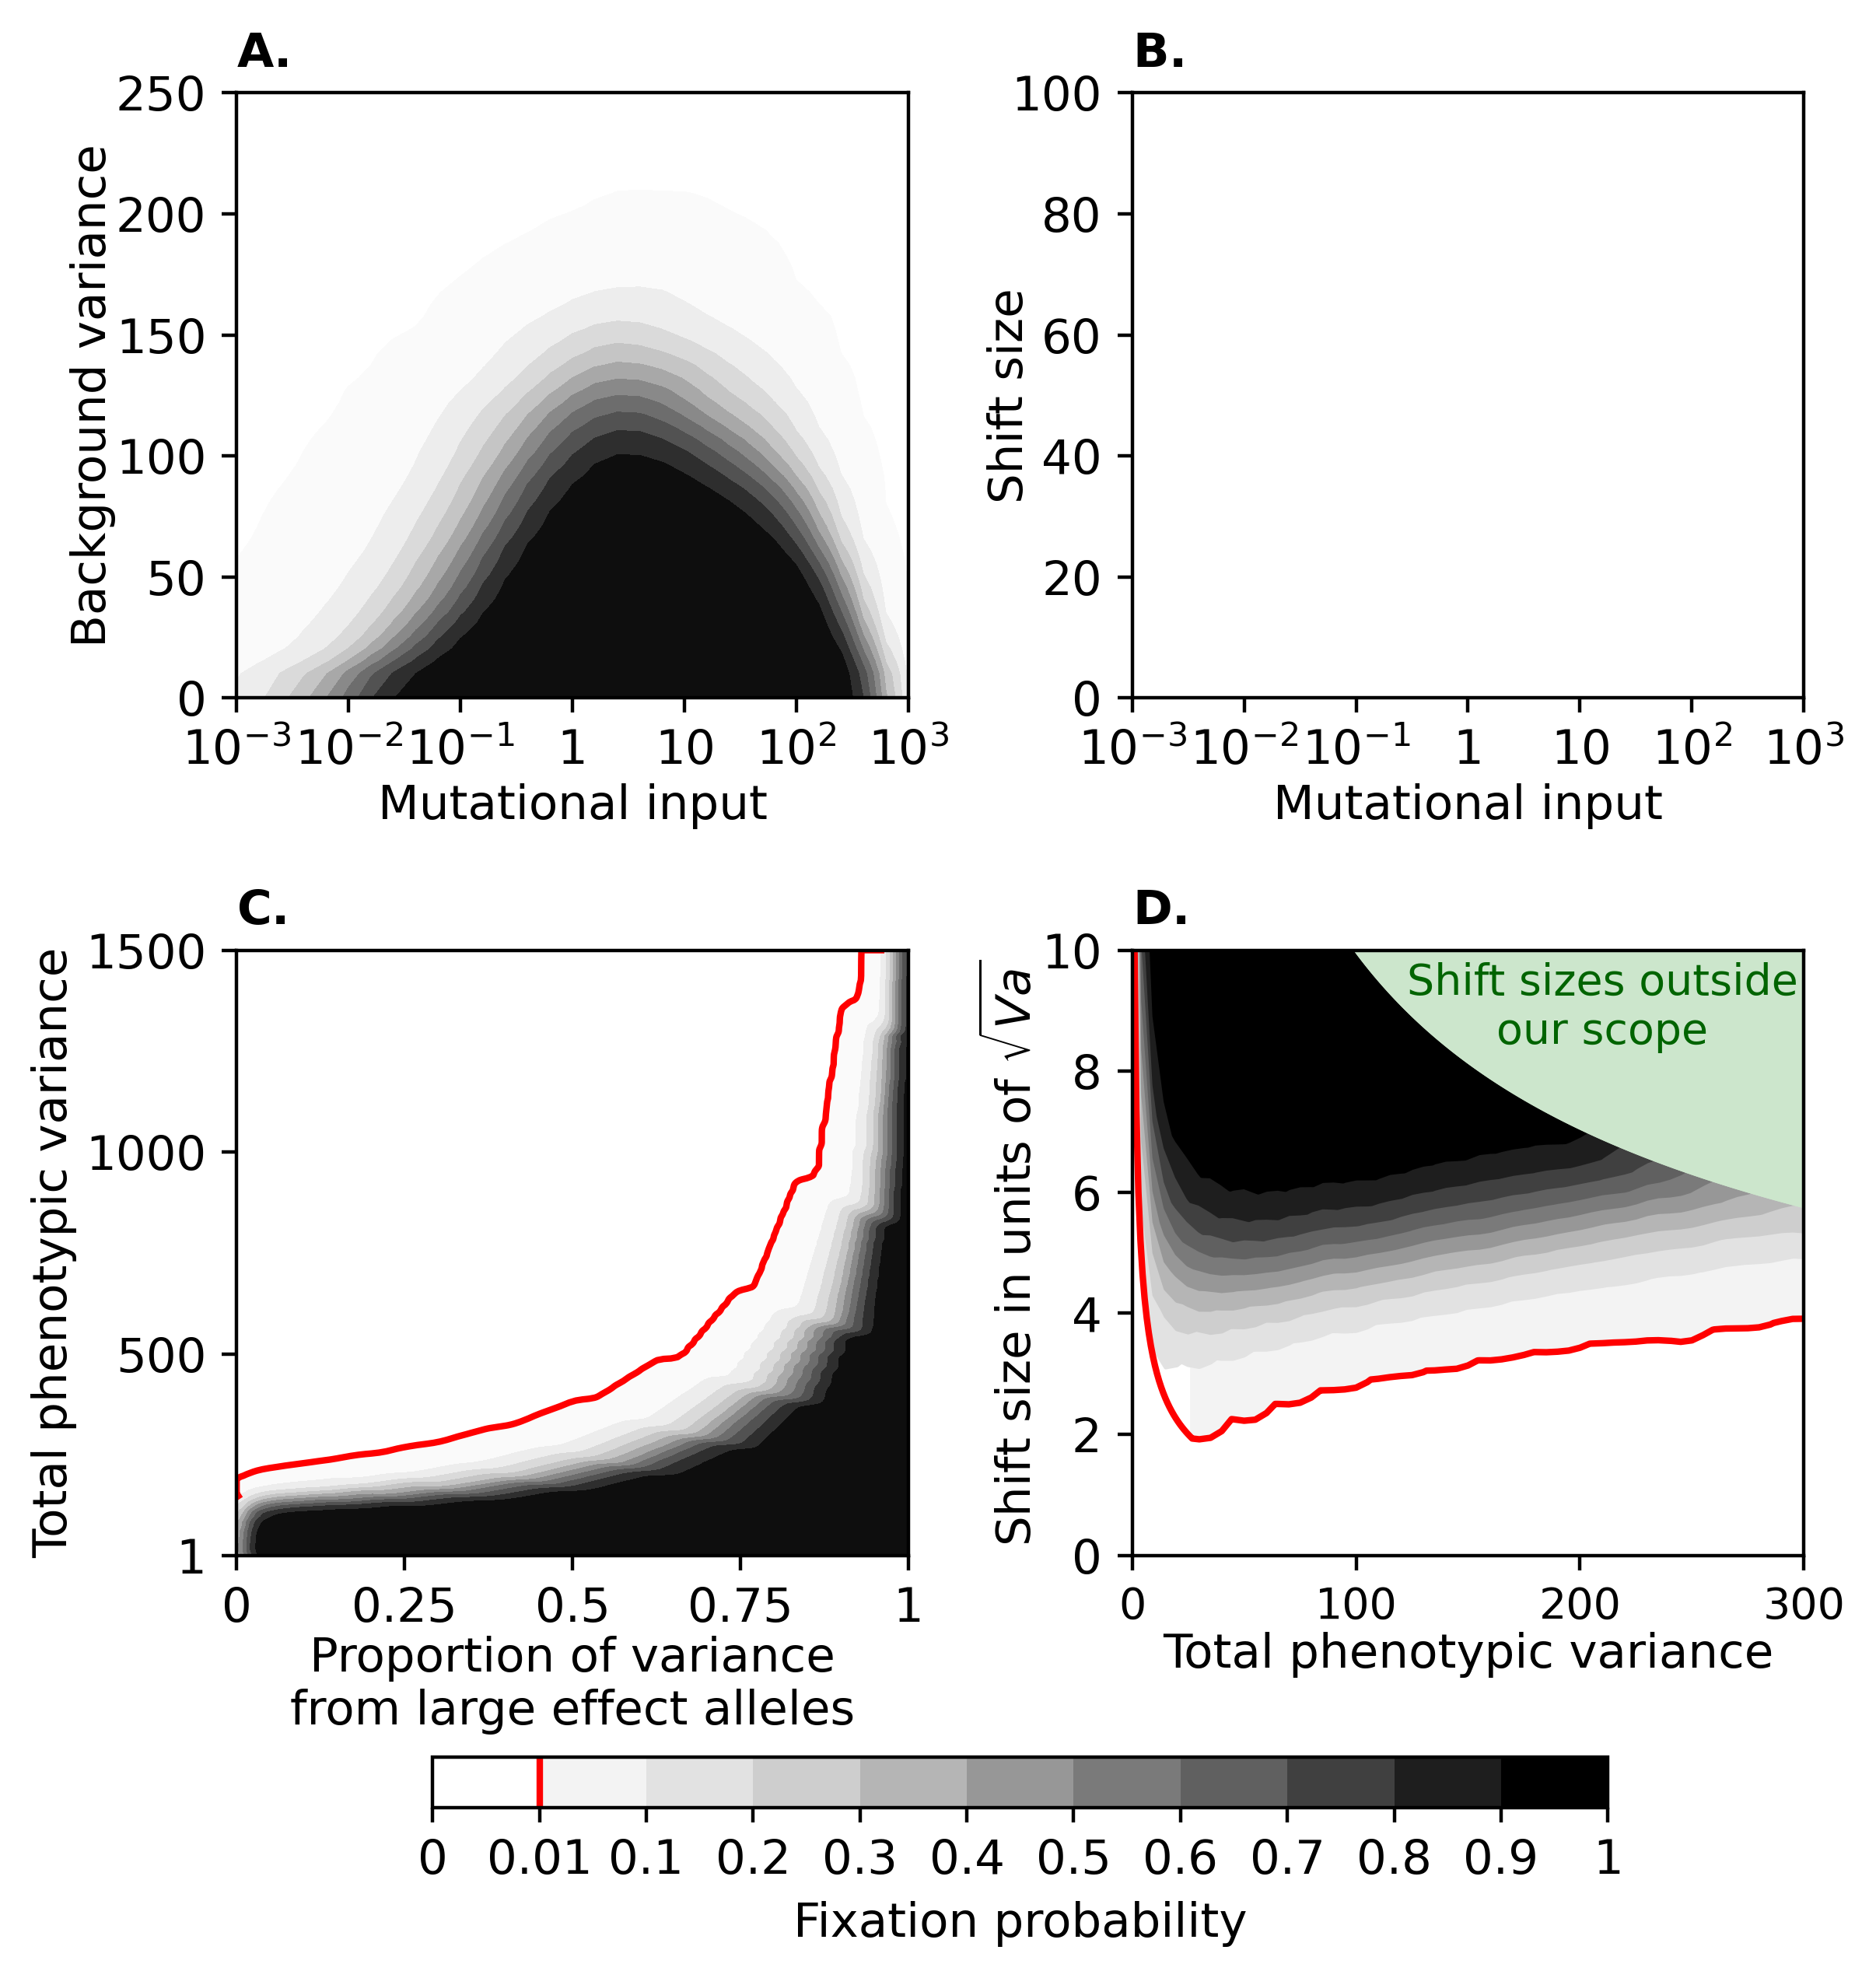

In [ ]:

fontsize=11

# fig,axes_all = plt.subplots(ncols=5,nrows=2,dpi=500,figsize=(7.5,6.7),gridspec_kw={'width_ratios':[24,8,24,4,2]})
fig, axes_all = plt.subplot_mosaic("ABC;HHH;DEF;GGG;III",figsize=(6.5,7.3),dpi=400,gridspec_kw={'width_ratios': [24,8,24],'height_ratios':[24,10,24,8,2]})

sigma2_2NU_ax = axes_all['A']
shift_2NU_ax = axes_all['C']
genetics_ax = axes_all['D']
ecology_ax = axes_all['F']
colorbar_ax = axes_all['I']
for name in ['B','G','E','H']:
    axes_all[name].axis('off')

# axes_all=[axes_all]
# axes_all = [[shift_2NU_ax,axes_all[0][1],axes_all[0][0],axes_all[0][3],axes_all[0][4],axes_all[0][5],axes_all[0][6]]]
sigma2_contour_plot(ax=sigma2_2NU_ax,results=results)
shift_contour_plot(ax=shift_2NU_ax,results=results_shift)


sigma2_2NU_ax.set_title(r'$\bf{A.}$',fontsize=fontsize,loc='left')
shift_2NU_ax.set_title(r'$\bf{B.}$',fontsize=fontsize,loc='left')
# shift_2NU_ax.set_title(r'$\bf{B.}$ Ecological parameter in dynamics\' units',fontsize=fontsize)

sigma2_2NU_ax.set_ylabel('Background variance',fontsize=fontsize,labelpad=0)
sigma2_2NU_ax.set_xlabel('Mutational input',fontsize=fontsize,labelpad=2)
shift_2NU_ax.set_xlabel('Mutational input',fontsize=fontsize,labelpad=2)
shift_2NU_ax.set_ylabel('Shift size',fontsize=fontsize,labelpad=-5)
sigma2_2NU_ax.set_yticks([0,50,100,150,200,250])
sigma2_2NU_ax.set_yticklabels([0,50,100,150,200,250],fontsize=fontsize)
sigma2_2NU_ax.set_xticks([1e-3,1e-2,1e-1,1,1e1,1e2,1e3])
sigma2_2NU_ax.set_xticklabels([r'$10^{-3}$',r'$10^{-2}$',r'$10^{-1}$',r'1',r'$10$',r'$10^{2}$',r'$10^{3}$'],fontsize=fontsize)
shift_2NU_ax.set_yticks([0,20,40,60,80,100])
shift_2NU_ax.set_yticklabels([0,20,40,60,80,100],fontsize=fontsize)
shift_2NU_ax.set_xticks([1e-3,1e-2,1e-1,1,1e1,1e2,1e3])
shift_2NU_ax.set_xticklabels([r'$10^{-3}$',r'$10^{-2}$',r'$10^{-1}$',r'1',r'$10$',r'$10^{2}$',r'$10^{3}$'],fontsize=fontsize)

ax = genetics_ax
ax.set_yticks([1,500,1000,1500])
ax.set_yticklabels(['1','500','1000','1500'],size=fontsize)
ax.set_xlabel('Proportion of variance\nfrom large effect alleles',size=fontsize,labelpad=1)
ax.set_ylabel('Total phenotypic variance',size=fontsize,labelpad=2)
ax.set_title(r'$\bf{C}.$',loc='left',size=fontsize)

with open('/Users/will_milligan/Desktop/Sella/Figure6C_plotting_data_shift80.pickle','rb') as fin:
    p_mesh,va_mesh,Z2 = pickle.load(fin)
gg=ax.contourf(p_mesh,va_mesh,Z2,levels=[0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],cmap=cmap)
ax.set_xlim([0,1])
ax.set_ylim([1,1500])
ax.set_xticks([0,0.25,0.5,0.75,1])
ax.set_xticklabels([0,0.25,0.5,0.75,1],size=fontsize)
# p_values = np.linspace(0,1,100)
# # ax.plot(p_values,200/(1-p_values),color='b',ls='--')
# for shift_dd,ls in zip([80],['-','--']):
#     a = 10
#     vvvv = (shift_dd-a)*a/(1-p_values)*1/(np.log(a**2))
#     ax.plot(vvvv,p_values,color='r',ls=ls)

ppp=gg.collections[0].get_paths()[0].vertices
xx = ppp[:,0]
yy = ppp[:,1]
x_right,y_right = [],[]
start = False
for x,y in zip(xx,yy):
    if x == max(xx):
        start = True
    if start:
        x_right.append(x)
        y_right.append(y)
ax.plot(x_right,y_right,color='r',ls='-')


paths = plot_figure_6_d(ax=ecology_ax,ax_cbar=colorbar_ax)
ax = ecology_ax

for path,color_i in zip(paths,[0.01]):
    
    ppath = path.get_paths()[0].vertices
    x = ppath[:,0]
    y = ppath[:,1]
    # ax.plot(x,[yy/np.sqrt(xx) for xx,yy in zip(x,y)],color=[1-color_i,1-color_i,1-color_i])
    x = np.append(np.linspace(0,min(x),30),x)
    y = np.append(np.linspace(10,y[0],30),y)
    ax.plot(x,[yy/np.sqrt(xx) for xx,yy in zip(x,y)],color='r')
        
ax.fill_between(np.linspace(0,500,501),[100/np.sqrt(x) for x in np.linspace(0,500,501)],[100]*501,color=[0.8,0.9,0.8])
    

ax.set_yticks([0,2,4,6,8,10])
ax.set_yticklabels([0,2,4,6,8,10],size=fontsize)
# ax.set_xticks([0,50,100,150,200,250,300])
# ax.set_xticklabels([0,50,100,150,200,250,300],size=fontsize)
ax.set_xlabel('Total phenotypic variance',size=fontsize,labelpad=1)
ax.set_ylabel('Shift size in units of $\sqrt{Va}$',size=fontsize,labelpad=0)
ax.set_title(r'$\bf{D}.$',loc='left',size=fontsize)
var_values = np.linspace(0,1500,500)
shift_values = 10/np.sqrt(var_values)+np.sqrt(var_values)/4
ax.set_xlim([0,300])
# ax.fill_between(var_values,100/np.sqrt(var_values),[100]*len(var_values),color='g',alpha=0.1,edgecolor='None')

# a = 10
# for p,ls in zip([0.5],['-','--']):
#     shift_values = -np.log(1/a**2)*np.sqrt(var_values)*(1-p)/a+a/np.sqrt(var_values)
#     ax.plot(var_values,shift_values,color='r',ls=ls)

plt.subplots_adjust(wspace=0,hspace=0)
# 
colorbar_ax.clear()

# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]

# create the new map
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)

# define the bins and normalize
bounds = [0,0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

cb1 = mpl.colorbar.ColorbarBase(ax=colorbar_ax, cmap=cmap,
                                norm=norm,label='Contribution to long-term adaptation',
                                ticks=bounds, boundaries=bounds, format='%1i',orientation='horizontal')
cb1.set_label('Fixation probability',size=fontsize)

cb1.set_ticks([0,0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
cb1.set_ticklabels([0,0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
cb1.ax.tick_params(labelsize=fontsize)

colorbar_ax.plot([1/11,1/11],[0,1],color='r')

def shrink_cbar(ax, shrink=0.75):
    b = ax.get_position()
    new_h = b.width*shrink
    pad = (b.width-new_h)/2.
    new_x0 = b.x0 + pad
    new_x1 = b.x1 - pad
    b.x0 = new_x0
    b.x1 = new_x1
    ax.set_position(b)
shrink_cbar(colorbar_ax)
# plt.tight_layout()
plt.savefig('/Users/will_milligan/Desktop/Sella/ShortPaper_Figure6_new.png',bbox_inches='tight',dpi=400)


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: The following kwargs were not used by contour: 'algorithm'
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in sqrt
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: overflow encountered in exp


0.2448260770085293 235.37292058929756 0.0021242885492016752
[0.67992713 0.68316799 0.68641696 0.68967399 0.69293902 0.69621201
 0.6994929  0.70278165 0.7060782  0.70938249 0.71269447 0.71601409
 0.7193413  0.72267603 0.72601823 0.72936785 0.73272482 0.73608909
 0.7394606  0.74283929 0.74622509 0.74961796 0.75301782 0.75642461
 0.75983828 0.76325876 0.76668598 0.77011989 0.77356041 0.77700748
 0.78046104 0.78392102 0.78738735 0.79085996 0.79433878 0.79782376
 0.80131481 0.80481187 0.80831486 0.81182372 0.81533838 0.81885876
 0.82238479 0.82591639 0.8294535  0.83299604 0.83654394 0.84009711
 0.84365549 0.847219   0.85078756 0.85436109 0.85793953 0.86152278
 0.86511077 0.86870343 0.87230067 0.87590242 0.87950859 0.88311911
 0.88673389 0.89035285 0.89397591 0.89760299 0.901234   0.90486887
 0.90850751 0.91214984 0.91579577 0.91944521 0.9230981  0.92675433
 0.93041383 0.9340765  0.93774227 0.94141105 0.94508275 0.94875728
 0.95243456 0.9561145  0.95979701 0.96348201 0.9671694  0.97085911
 0

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:83: RuntimeWarning: divide by zero encountered in double_scalars
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:85: RuntimeWarning: divide by zero encountered in double_scalars
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:96: RuntimeWarning: divide by zero encountered in true_divide


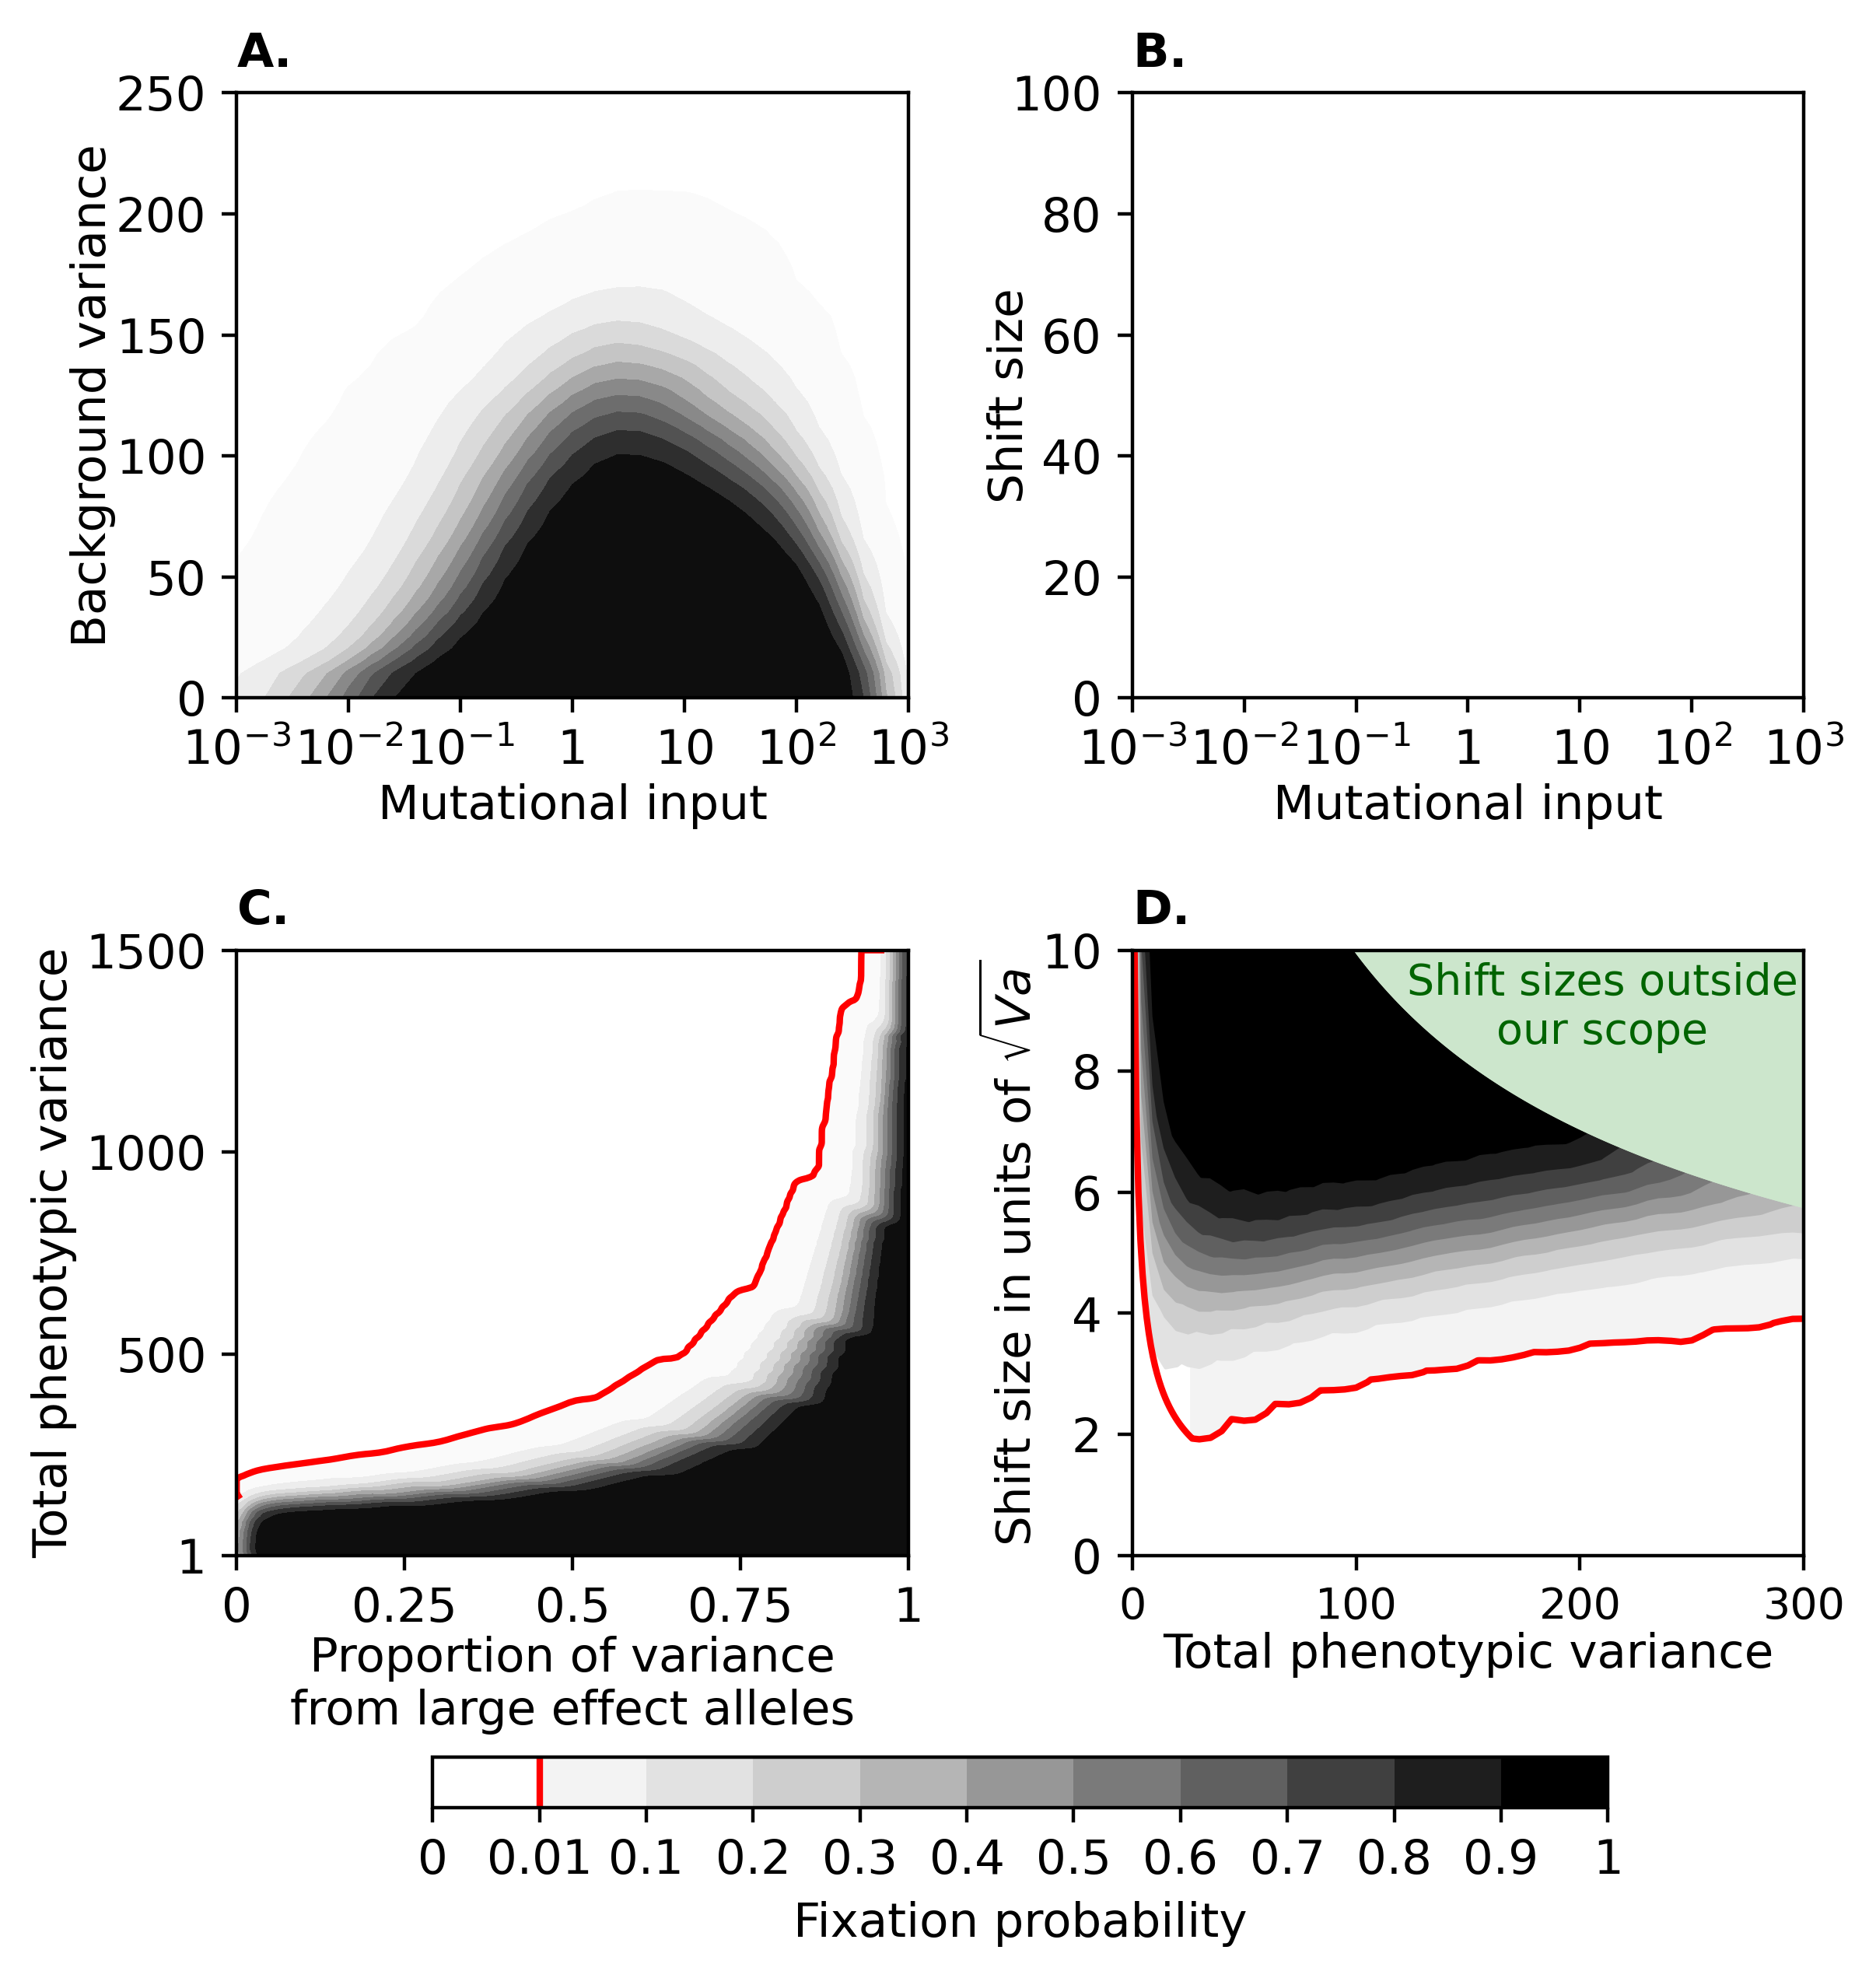

In [ ]:

fontsize=11

# fig,axes_all = plt.subplots(ncols=5,nrows=2,dpi=500,figsize=(7.5,6.7),gridspec_kw={'width_ratios':[24,8,24,4,2]})
fig, axes_all = plt.subplot_mosaic("ABC;HHH;DEF;GGG;III",figsize=(6.5,7.3),dpi=400,gridspec_kw={'width_ratios': [24,8,24],'height_ratios':[24,10,24,8,2]})

sigma2_2NU_ax = axes_all['A']
shift_2NU_ax = axes_all['C']
genetics_ax = axes_all['D']
ecology_ax = axes_all['F']
colorbar_ax = axes_all['I']
for name in ['B','G','E','H']:
    axes_all[name].axis('off')

# axes_all=[axes_all]
# axes_all = [[shift_2NU_ax,axes_all[0][1],axes_all[0][0],axes_all[0][3],axes_all[0][4],axes_all[0][5],axes_all[0][6]]]
sigma2_contour_plot(ax=sigma2_2NU_ax,results=results)
shift_contour_plot(ax=shift_2NU_ax,results=results_shift)


sigma2_2NU_ax.set_title(r'$\bf{A.}$',fontsize=fontsize,loc='left')
shift_2NU_ax.set_title(r'$\bf{B.}$',fontsize=fontsize,loc='left')
# shift_2NU_ax.set_title(r'$\bf{B.}$ Ecological parameter in dynamics\' units',fontsize=fontsize)

sigma2_2NU_ax.set_ylabel('Background variance',fontsize=fontsize,labelpad=0)
sigma2_2NU_ax.set_xlabel('Mutational input',fontsize=fontsize,labelpad=2)
shift_2NU_ax.set_xlabel('Mutational input',fontsize=fontsize,labelpad=2)
shift_2NU_ax.set_ylabel('Shift size',fontsize=fontsize,labelpad=-5)
sigma2_2NU_ax.set_yticks([0,50,100,150,200,250])
sigma2_2NU_ax.set_yticklabels([0,50,100,150,200,250],fontsize=fontsize)
sigma2_2NU_ax.set_xticks([1e-3,1e-2,1e-1,1,1e1,1e2,1e3])
sigma2_2NU_ax.set_xticklabels([r'$10^{-3}$',r'$10^{-2}$',r'$10^{-1}$',r'1',r'$10$',r'$10^{2}$',r'$10^{3}$'],fontsize=fontsize)
shift_2NU_ax.set_yticks([0,20,40,60,80,100])
shift_2NU_ax.set_yticklabels([0,20,40,60,80,100],fontsize=fontsize)
shift_2NU_ax.set_xticks([1e-3,1e-2,1e-1,1,1e1,1e2,1e3])
shift_2NU_ax.set_xticklabels([r'$10^{-3}$',r'$10^{-2}$',r'$10^{-1}$',r'1',r'$10$',r'$10^{2}$',r'$10^{3}$'],fontsize=fontsize)

ax = genetics_ax
ax.set_yticks([1,500,1000,1500])
ax.set_yticklabels(['1','500','1000','1500'],size=fontsize)
ax.set_xlabel('Proportion of variance\nfrom large effect alleles',size=fontsize,labelpad=1)
ax.set_ylabel('Total phenotypic variance',size=fontsize,labelpad=2)
ax.set_title(r'$\bf{C}.$',loc='left',size=fontsize)

with open('/Users/will_milligan/Desktop/Sella/Figure6C_plotting_data_shift80.pickle','rb') as fin:
    p_mesh,va_mesh,Z2 = pickle.load(fin)
gg=ax.contourf(p_mesh,va_mesh,Z2,levels=[0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],cmap=cmap)
ax.set_xlim([0,1])
ax.set_ylim([1,1500])
ax.set_xticks([0,0.25,0.5,0.75,1])
ax.set_xticklabels([0,0.25,0.5,0.75,1],size=fontsize)
# p_values = np.linspace(0,1,100)
# # ax.plot(p_values,200/(1-p_values),color='b',ls='--')
# for shift_dd,ls in zip([80],['-','--']):
#     a = 10
#     vvvv = (shift_dd-a)*a/(1-p_values)*1/(np.log(a**2))
#     ax.plot(vvvv,p_values,color='r',ls=ls)

ppp=gg.collections[0].get_paths()[0].vertices
xx = ppp[:,0]
yy = ppp[:,1]
x_right,y_right = [],[]
start = False
for x,y in zip(xx,yy):
    if x == max(xx):
        start = True
    if start:
        x_right.append(x)
        y_right.append(y)
ax.plot(x_right,y_right,color='r',ls='-')


paths = plot_figure_6_d(ax=ecology_ax,ax_cbar=colorbar_ax)
ax = ecology_ax

for path,color_i in zip(paths,[0.01]):
    
    ppath = path.get_paths()[0].vertices
    x = ppath[:,0]
    y = ppath[:,1]
    # ax.plot(x,[yy/np.sqrt(xx) for xx,yy in zip(x,y)],color=[1-color_i,1-color_i,1-color_i])
    x = np.append(np.linspace(0,min(x),30),x)
    y = np.append(np.linspace(10,y[0],30),y)
    ax.plot(x,[yy/np.sqrt(xx) for xx,yy in zip(x,y)],color='r')
        
ax.fill_between(np.linspace(0,500,501),[100/np.sqrt(x) for x in np.linspace(0,500,501)],[100]*501,color=[0.8,0.9,0.8])
    

ax.set_yticks([0,2,4,6,8,10])
ax.set_yticklabels([0,2,4,6,8,10],size=fontsize)
# ax.set_xticks([0,50,100,150,200,250,300])
# ax.set_xticklabels([0,50,100,150,200,250,300],size=fontsize)
ax.set_xlabel('Total phenotypic variance',size=fontsize,labelpad=1)
ax.set_ylabel('Shift size in units of $\sqrt{Va}$',size=fontsize,labelpad=0)
ax.set_title(r'$\bf{D}.$',loc='left',size=fontsize)
var_values = np.linspace(0,1500,500)
shift_values = 10/np.sqrt(var_values)+np.sqrt(var_values)/4
ax.set_xlim([0,300])
# ax.fill_between(var_values,100/np.sqrt(var_values),[100]*len(var_values),color='g',alpha=0.1,edgecolor='None')

# a = 10
# for p,ls in zip([0.5],['-','--']):
#     shift_values = -np.log(1/a**2)*np.sqrt(var_values)*(1-p)/a+a/np.sqrt(var_values)
#     ax.plot(var_values,shift_values,color='r',ls=ls)

plt.subplots_adjust(wspace=0,hspace=0)
# 
colorbar_ax.clear()

# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]

# create the new map
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)

# define the bins and normalize
bounds = [0,0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

cb1 = mpl.colorbar.ColorbarBase(ax=colorbar_ax, cmap=cmap,
                                norm=norm,label='Contribution to long-term adaptation',
                                ticks=bounds, boundaries=bounds, format='%1i',orientation='horizontal')
cb1.set_label('Fixation probability',size=fontsize)

cb1.set_ticks([0,0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
cb1.set_ticklabels([0,0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
cb1.ax.tick_params(labelsize=fontsize)

colorbar_ax.plot([1/11,1/11],[0,1],color='r')

def shrink_cbar(ax, shrink=0.75):
    b = ax.get_position()
    new_h = b.width*shrink
    pad = (b.width-new_h)/2.
    new_x0 = b.x0 + pad
    new_x1 = b.x1 - pad
    b.x0 = new_x0
    b.x1 = new_x1
    ax.set_position(b)
shrink_cbar(colorbar_ax)
# plt.tight_layout()
plt.savefig('/Users/will_milligan/Desktop/Sella/ShortPaper_Figure6_new.png',bbox_inches='tight',dpi=400)


0.0184375


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: The following kwargs were not used by contour: 'algorithm'
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in sqrt
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: overflow encountered in exp


0.2448260770085293 235.37292058929756 0.0021242885492016752
[0.67992713 0.68316799 0.68641696 0.68967399 0.69293902 0.69621201
 0.6994929  0.70278165 0.7060782  0.70938249 0.71269447 0.71601409
 0.7193413  0.72267603 0.72601823 0.72936785 0.73272482 0.73608909
 0.7394606  0.74283929 0.74622509 0.74961796 0.75301782 0.75642461
 0.75983828 0.76325876 0.76668598 0.77011989 0.77356041 0.77700748
 0.78046104 0.78392102 0.78738735 0.79085996 0.79433878 0.79782376
 0.80131481 0.80481187 0.80831486 0.81182372 0.81533838 0.81885876
 0.82238479 0.82591639 0.8294535  0.83299604 0.83654394 0.84009711
 0.84365549 0.847219   0.85078756 0.85436109 0.85793953 0.86152278
 0.86511077 0.86870343 0.87230067 0.87590242 0.87950859 0.88311911
 0.88673389 0.89035285 0.89397591 0.89760299 0.901234   0.90486887
 0.90850751 0.91214984 0.91579577 0.91944521 0.9230981  0.92675433
 0.93041383 0.9340765  0.93774227 0.94141105 0.94508275 0.94875728
 0.95243456 0.9561145  0.95979701 0.96348201 0.9671694  0.97085911
 0

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in double_scalars
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:146: RuntimeWarning: divide by zero encountered in double_scalars


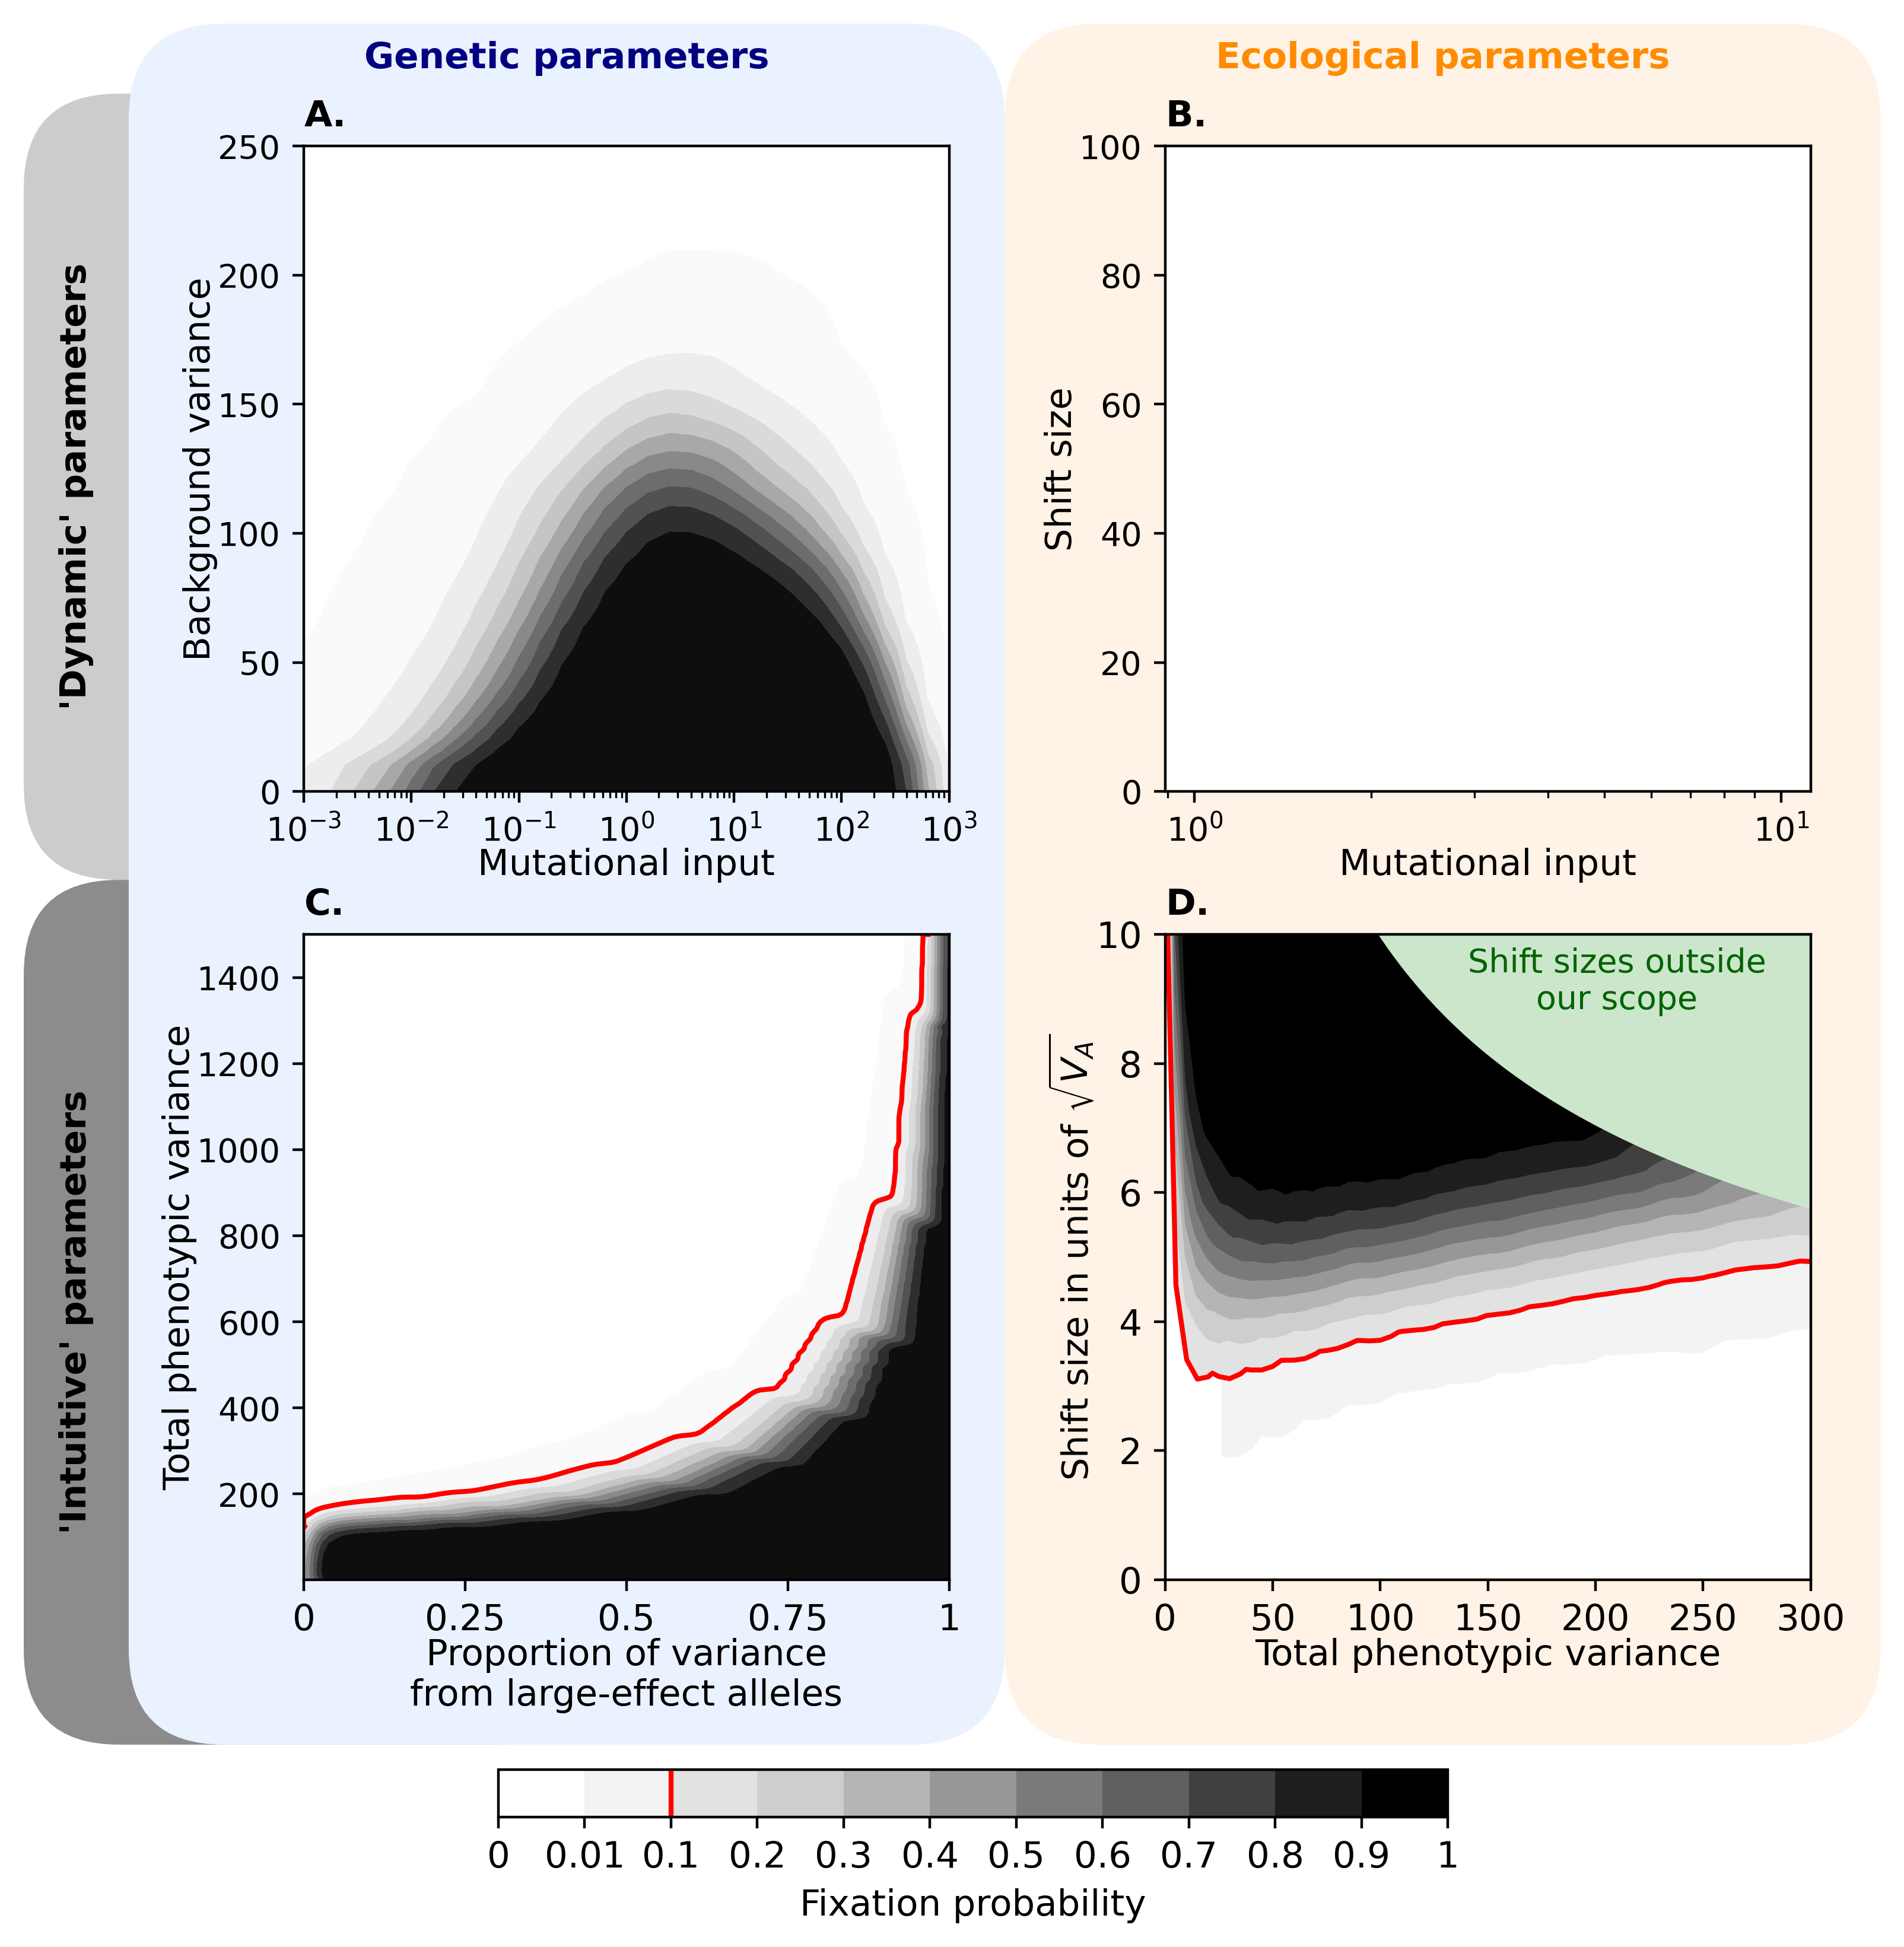

In [ ]:

fontsize=11
from matplotlib.patches import Rectangle, FancyBboxPatch
facecolor=[0.92,0.95,1]
# fig,axes_all = plt.subplots(ncols=5,nrows=2,dpi=500,figsize=(7.5,6.7),gridspec_kw={'width_ratios':[24,8,24,4,2]})
# fig, axes_all = plt.subplot_mosaic("ABC;HHH;DEF;GGG;III",figsize=(6.5,7.3),dpi=400,gridspec_kw={'width_ratios': [24,8,24],'height_ratios':[24,10,24,8,2]})
fig = plt.figure(figsize=(8,8),dpi=400)
z = fig.add_axes(rect=[0,0,1,1])
z.set_xticks([])
z.set_yticks([])

r = fig.canvas.get_renderer()
t = z.text(0.5,0.5,'Figure 6',fontsize=fontsize,ha='center',va='center')
bb = t.get_window_extent(renderer=r)
width = bb.width
height = bb.height/fig.dpi
text_pad = height/8
t.remove()
z.remove()

print(text_pad)
space_between_axes = 0.02
space_between_colorbar = 0.1
horizontal_space_between_axes=0.04
colorbar = fig.add_axes(rect=[0.25,3*text_pad,0.5,0.2/8])
current_y = 0.2/8+3*text_pad + space_between_colorbar
max_y = 1-3.5*text_pad
remaining_height = max_y-current_y
min_x = 8*text_pad
max_x = 1#-text_pad

height = (remaining_height-3*text_pad-space_between_axes)/2



c = fig.add_axes(rect=[min_x,current_y,height,height])
d = fig.add_axes(rect=[min_x+height+horizontal_space_between_axes+text_pad*4,current_y,height,height])
current_y += height+space_between_axes+3*text_pad
a = fig.add_axes(rect=[min_x,current_y,height,height])
b = fig.add_axes(rect=[min_x+height+horizontal_space_between_axes+text_pad*4,current_y,height,height])


a.set_title(r'$\bf{A.}$',fontsize=fontsize,loc='left')
a.set_ylabel('Background variance',fontsize=fontsize,labelpad=0)
a.set_xlabel('Mutational input',fontsize=fontsize,labelpad=0)

b.set_title(r'$\bf{B.}$',fontsize=fontsize,loc='left')
b.set_ylabel('Shift size',fontsize=fontsize,labelpad=0)
b.set_xlabel('Mutational input',fontsize=fontsize,labelpad=0)

c.set_title(r'$\bf{C.}$',fontsize=fontsize,loc='left')
c.set_xlabel('Proportion of variance\nfrom large effect alleles',fontsize=fontsize,labelpad=0)
c.set_ylabel('Total phenotypic variance',fontsize=fontsize,labelpad=0)

d.set_title(r'$\bf{D.}$',fontsize=fontsize,loc='left')
d.set_xlabel('Total phenotypic variance',fontsize=fontsize,labelpad=0)
d.set_ylabel('Shift size in units of $\sqrt{Va}$',fontsize=fontsize,labelpad=0)






# sigma2_2NU_ax = axes_all['A']
# shift_2NU_ax = axes_all['C']
# genetics_ax = axes_all['D']
# ecology_ax = axes_all['F']
# colorbar_ax = axes_all['I']
# for name in ['B','G','E','H']:
#     axes_all[name].axis('off')

# # axes_all=[axes_all]
# # axes_all = [[shift_2NU_ax,axes_all[0][1],axes_all[0][0],axes_all[0][3],axes_all[0][4],axes_all[0][5],axes_all[0][6]]]
sigma2_contour_plot(ax=a,results=results)
shift_contour_plot(ax=b,results=results_shift)


# sigma2_2NU_ax.set_title(r'$\bf{A.}$',fontsize=fontsize,loc='left')
# shift_2NU_ax.set_title(r'$\bf{B.}$',fontsize=fontsize,loc='left')
# # shift_2NU_ax.set_title(r'$\bf{B.}$ Ecological parameter in dynamics\' units',fontsize=fontsize)

# sigma2_2NU_ax.set_ylabel('Background variance',fontsize=fontsize,labelpad=0)
# sigma2_2NU_ax.set_xlabel('Mutational input',fontsize=fontsize,labelpad=2)
# shift_2NU_ax.set_xlabel('Mutational input',fontsize=fontsize,labelpad=2)
# shift_2NU_ax.set_ylabel('Shift size',fontsize=fontsize,labelpad=-5)
# sigma2_2NU_ax.set_yticks([0,50,100,150,200,250])
# sigma2_2NU_ax.set_yticklabels([0,50,100,150,200,250],fontsize=fontsize)
# sigma2_2NU_ax.set_xticks([1e-3,1e-2,1e-1,1,1e1,1e2,1e3])
# sigma2_2NU_ax.set_xticklabels([r'$10^{-3}$',r'$10^{-2}$',r'$10^{-1}$',r'1',r'$10$',r'$10^{2}$',r'$10^{3}$'],fontsize=fontsize)
# shift_2NU_ax.set_yticks([0,20,40,60,80,100])
# shift_2NU_ax.set_yticklabels([0,20,40,60,80,100],fontsize=fontsize)
# shift_2NU_ax.set_xticks([1e-3,1e-2,1e-1,1,1e1,1e2,1e3])
# shift_2NU_ax.set_xticklabels([r'$10^{-3}$',r'$10^{-2}$',r'$10^{-1}$',r'1',r'$10$',r'$10^{2}$',r'$10^{3}$'],fontsize=fontsize)

# ax = genetics_ax
# ax.set_yticks([1,500,1000,1500])
# ax.set_yticklabels(['1','500','1000','1500'],size=fontsize)
# ax.set_ylabel('Proportion of variance\nfrom large effect alleles',size=fontsize,labelpad=1)
# ax.set_xlabel('Total phenotypic variance',size=fontsize,labelpad=2)
# ax.set_title(r'$\bf{C}.$',loc='left',size=fontsize)

with open('/Users/will_milligan/Desktop/Sella/Figure6C_plotting_data_shift80.pickle','rb') as fin:
    p_mesh,va_mesh,Z2 = pickle.load(fin)
# with open('/Users/will_milligan/Desktop/Sella/shift_80_alt_parameters_concat_over_shift_values.pickle.gz','rb') as fin:
#     results_z = pickle.load(fin)


gg=c.contourf(p_mesh,va_mesh,Z2,levels=[0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],cmap=cmap)
c.set_xlim([0,1])
c.set_ylim([1,1500])
c.set_xticks([0,0.25,0.5,0.75,1])
c.set_xticklabels([0,0.25,0.5,0.75,1],size=fontsize)
# # p_values = np.linspace(0,1,100)
# # # ax.plot(p_values,200/(1-p_values),color='b',ls='--')
# # for shift_dd,ls in zip([80],['-','--']):
# #     a = 10
# #     vvvv = (shift_dd-a)*a/(1-p_values)*1/(np.log(a**2))
# #     ax.plot(vvvv,p_values,color='r',ls=ls)

ppp=gg.collections[1].get_paths()[0].vertices
xx = ppp[:,0]
yy = ppp[:,1]
x_right,y_right = [],[]
start = False
for x,y in zip(xx,yy):
    if x == max(xx):
        start = True
    if start:
        x_right.append(x)
        y_right.append(y)
c.plot(x_right,y_right,color='r',ls='-')


paths = plot_figure_6_d(ax=d,ax_cbar=colorbar)
# ax = ecology_ax

for path,color_i in zip(paths,[0.01,0.1]):
    if color_i == 0.01: continue
    ppath = path.get_paths()[0].vertices
    x = ppath[:,0]
    y = ppath[:,1]
#     # ax.plot(x,[yy/np.sqrt(xx) for xx,yy in zip(x,y)],color=[1-color_i,1-color_i,1-color_i])
    x = np.append(np.linspace(0,min(x),30),x)
    y = np.append(np.linspace(10,y[0],30),y)
    d.plot(x,[yy/np.sqrt(xx) for xx,yy in zip(x,y)],color='r')
        
d.fill_between(np.linspace(0,500,501),[100/np.sqrt(x) for x in np.linspace(0,500,501)],[100]*501,color=[0.8,0.9,0.8])
    

d.set_yticks([0,2,4,6,8,10])
d.set_yticklabels([0,2,4,6,8,10],size=fontsize)
d.set_xticks([0,50,100,150,200,250,300])
d.set_xticklabels([0,50,100,150,200,250,300],size=fontsize)
d.set_xlabel('Total phenotypic variance',size=fontsize,labelpad=1)
d.set_ylabel('Shift size in units of $\sqrt{Va}$',size=fontsize,labelpad=0)
# ax.set_title(r'$\bf{D}.$',loc='left',size=fontsize)
# var_values = np.linspace(0,1500,500)
# shift_values = 10/np.sqrt(var_values)+np.sqrt(var_values)/4
ax.set_xlim([0,300])
# # ax.fill_between(var_values,100/np.sqrt(var_values),[100]*len(var_values),color='g',alpha=0.1,edgecolor='None')

# # a = 10
# # for p,ls in zip([0.5],['-','--']):
# #     shift_values = -np.log(1/a**2)*np.sqrt(var_values)*(1-p)/a+a/np.sqrt(var_values)
# #     ax.plot(var_values,shift_values,color='r',ls=ls)

# plt.subplots_adjust(wspace=0,hspace=0)
# # 
colorbar.clear()

# # extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]

# create the new map
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)

# define the bins and normalize
bounds = [0,0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

cb1 = mpl.colorbar.ColorbarBase(ax=colorbar, cmap=cmap,
                                norm=norm,label='Contribution to long-term adaptation',
                                ticks=bounds, boundaries=bounds, format='%1i',orientation='horizontal')
cb1.set_label('Fixation probability',size=fontsize)

cb1.set_ticks([0,0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
cb1.set_ticklabels([0,0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
cb1.ax.tick_params(labelsize=fontsize)

colorbar.plot([2/11,2/11],[0,1],color='r')

# def shrink_cbar(ax, shrink=0.75):
#     b = ax.get_position()
#     new_h = b.width*shrink
#     pad = (b.width-new_h)/2.
#     new_x0 = b.x0 + pad
#     new_x1 = b.x1 - pad
#     b.x0 = new_x0
#     b.x1 = new_x1
#     ax.set_position(b)
# shrink_cbar(colorbar_ax)
# # plt.savefig('/Users/will_milligan/Desktop/Sella/ShortPaper_Figure6_new.png',bbox_inches='tight')

a.set_title(r'$\bf{A.}$',fontsize=fontsize,loc='left')
a.set_ylabel('Background variance',fontsize=fontsize,labelpad=0)
a.set_xlabel('Mutational input',fontsize=fontsize,labelpad=0)

b.set_title(r'$\bf{B.}$',fontsize=fontsize,loc='left')
b.set_ylabel('Shift size',fontsize=fontsize,labelpad=0)
b.set_xlabel('Mutational input',fontsize=fontsize,labelpad=0)

c.set_title(r'$\bf{C.}$',fontsize=fontsize,loc='left')
c.set_xlabel('Proportion of variance\nfrom large-effect alleles',fontsize=fontsize,labelpad=0)
c.set_ylabel('Total phenotypic variance',fontsize=fontsize,labelpad=0)

d.set_title(r'$\bf{D.}$',fontsize=fontsize,loc='left')
d.set_xlabel('Total phenotypic variance',fontsize=fontsize,labelpad=0)
d.set_ylabel('Shift size in units of $\sqrt{V_A}$',fontsize=fontsize,labelpad=0)

vertical_lower_y = 0.2/8 + 1*text_pad + space_between_colorbar/2
vertical_upper_y = 1
vertical_height = vertical_upper_y-vertical_lower_y
vertical_left_x = min_x-text_pad*5
vertical_left_width = min_x-text_pad*3+height+horizontal_space_between_axes/2+text_pad/2
vertical_right_x = vertical_left_width+vertical_left_x
vertical_right_max_x = min_x+height+horizontal_space_between_axes+text_pad*4+height+text_pad*2
vertical_right_width = vertical_right_max_x-vertical_right_x

horizontal_lower_x = 0
horizontal_upper_x = 1
horizontal_lower_y_min = vertical_lower_y
horizontal_lower_y_max = vertical_lower_y+height+text_pad*6+space_between_axes/2-0.005
horizontal_upper_y_min = horizontal_lower_y_max
horizontal_upper_y_max = 1 - 2*text_pad
fig.patches.extend([FancyBboxPatch((horizontal_lower_x,horizontal_lower_y_min),0.3,horizontal_lower_y_max-horizontal_lower_y_min, boxstyle='Round, pad=0,rounding_size=0.05', mutation_aspect=1,facecolor=[0.55,0.55,0.55],edgecolor='None',clip_on=False,transform=fig.transFigure, figure=fig,zorder=-1)])
fig.patches.extend([FancyBboxPatch((horizontal_lower_x,horizontal_upper_y_min),0.3,horizontal_upper_y_max-horizontal_upper_y_min, boxstyle='Round, pad=0,rounding_size=0.05', mutation_aspect=1,facecolor=[0.8,0.8,0.8],edgecolor='None',clip_on=False,transform=fig.transFigure, figure=fig,zorder=-1)])
fig.patches.extend([FancyBboxPatch((vertical_left_x,vertical_lower_y),vertical_left_width,vertical_height, boxstyle='Round, pad=0,rounding_size=0.05', mutation_aspect=1,facecolor=facecolor,edgecolor='None',clip_on=False,transform=fig.transFigure, figure=fig,zorder=-1)])
fig.patches.extend([FancyBboxPatch((vertical_right_x,vertical_lower_y),vertical_right_width,vertical_height, boxstyle='Round, pad=0,rounding_size=0.05', mutation_aspect=1,facecolor=[1,0.95,0.9],edgecolor='None',clip_on=False,transform=fig.transFigure, figure=fig,zorder=-1)])   


fig.text(x=vertical_left_x+vertical_left_width/2,y=(vertical_upper_y+horizontal_upper_y_max)/2,s='Genetic parameters',weight='bold',fontsize=fontsize,ha='center',verticalalignment='center',color='navy')
fig.text(x=vertical_right_x+vertical_right_width/2,y=(vertical_upper_y+horizontal_upper_y_max)/2,weight='bold',s='Ecological parameters',fontsize=fontsize,ha='center',va='center',color='darkorange')
fig.text(x=vertical_left_x/2,y=(horizontal_lower_y_min+horizontal_lower_y_max)/2,s="'Intuitive' parameters",weight="bold",fontsize=fontsize,ha='center',va='center',rotation=90,color='k')
fig.text(x=vertical_left_x/2,y=(horizontal_upper_y_min+horizontal_upper_y_max)/2,s="'Dynamic' parameters",weight="bold",fontsize=fontsize,ha='center',va='center',rotation=90,color='k')
plt.savefig('/Users/will_milligan/Desktop/Sella/ShortPaper_Figure6_newnew.png',bbox_inches='tight',dpi=400)


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: The following kwargs were not used by contour: 'algorithm'
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in sqrt
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: overflow encountered in exp


0.2448260770085293 235.37292058929756 0.0021242885492016752
[0.67992713 0.68316799 0.68641696 0.68967399 0.69293902 0.69621201
 0.6994929  0.70278165 0.7060782  0.70938249 0.71269447 0.71601409
 0.7193413  0.72267603 0.72601823 0.72936785 0.73272482 0.73608909
 0.7394606  0.74283929 0.74622509 0.74961796 0.75301782 0.75642461
 0.75983828 0.76325876 0.76668598 0.77011989 0.77356041 0.77700748
 0.78046104 0.78392102 0.78738735 0.79085996 0.79433878 0.79782376
 0.80131481 0.80481187 0.80831486 0.81182372 0.81533838 0.81885876
 0.82238479 0.82591639 0.8294535  0.83299604 0.83654394 0.84009711
 0.84365549 0.847219   0.85078756 0.85436109 0.85793953 0.86152278
 0.86511077 0.86870343 0.87230067 0.87590242 0.87950859 0.88311911
 0.88673389 0.89035285 0.89397591 0.89760299 0.901234   0.90486887
 0.90850751 0.91214984 0.91579577 0.91944521 0.9230981  0.92675433
 0.93041383 0.9340765  0.93774227 0.94141105 0.94508275 0.94875728
 0.95243456 0.9561145  0.95979701 0.96348201 0.9671694  0.97085911
 0

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: divide by zero encountered in true_divide
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: divide by zero encountered in true_divide


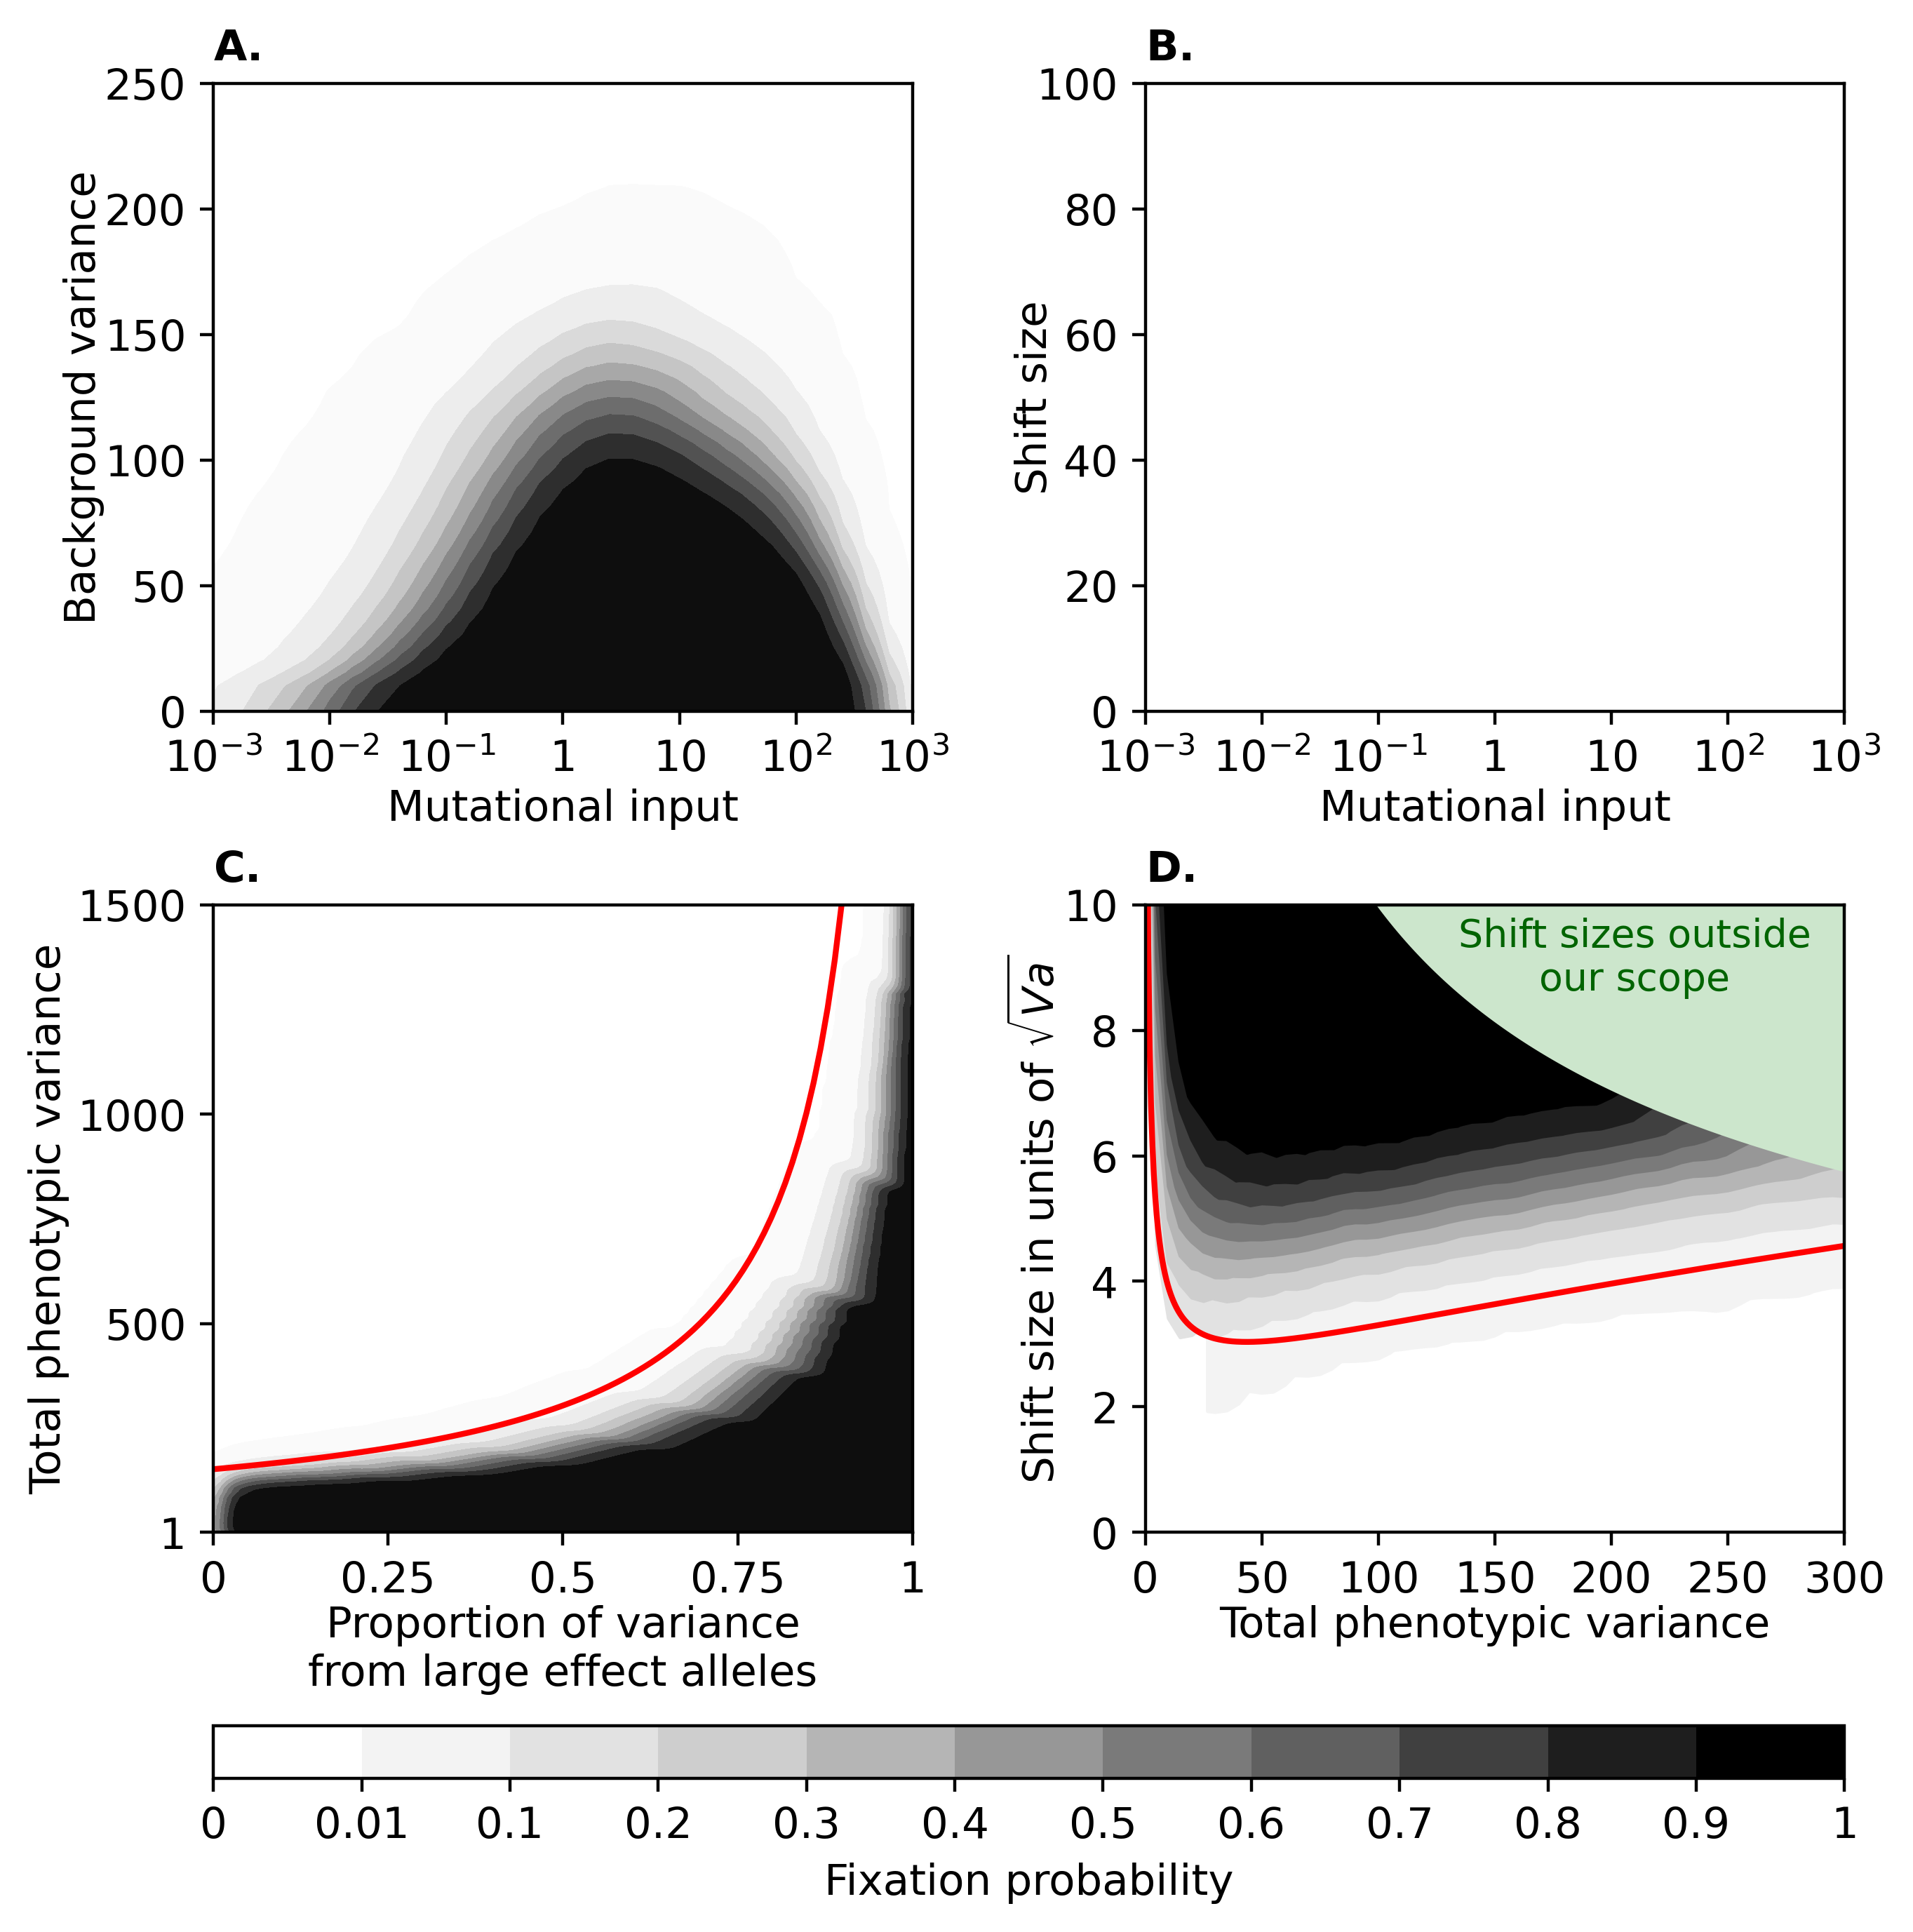

In [ ]:

# fig,axes_all = plt.subplots(ncols=5,nrows=2,dpi=500,figsize=(7.5,6.7),gridspec_kw={'width_ratios':[24,8,24,4,2]})
fig, axes_all = plt.subplot_mosaic("ABC;GGG;DEF;JJJ;KKK",figsize=(7.5,8),dpi=400,gridspec_kw={'width_ratios': [24,8,24],'height_ratios':[24,2,24,2,2]})


# axes_all=[axes_all]
# axes_all = [[axes_all[0][2],axes_all[0][1],axes_all[0][0],axes_all[0][3],axes_all[0][4],axes_all[0][5],axes_all[0][6]]]
sigma2_contour_plot(ax=axes_all['A'],results=results)
shift_contour_plot(ax=axes_all['C'],results=results_shift)


axes_all['A'].set_title(r'$\bf{A.}$',fontsize=fontsize,loc='left')
axes_all['C'].set_title(r'$\bf{B.}$',fontsize=fontsize,loc='left')
# axes_all[0][2].set_title(r'$\bf{B.}$ Ecological parameter in dynamics\' units',fontsize=fontsize)

axes_all['A'].set_ylabel('Background variance',fontsize=fontsize,labelpad=0)
axes_all['A'].set_xlabel('Mutational input',fontsize=fontsize,labelpad=2)
axes_all['C'].set_xlabel('Mutational input',fontsize=fontsize,labelpad=2)
axes_all['C'].set_ylabel('Shift size',fontsize=fontsize,labelpad=-5)
axes_all['A'].set_yticks([0,50,100,150,200,250])
axes_all['A'].set_yticklabels([0,50,100,150,200,250],fontsize=fontsize)
axes_all['A'].set_xticks([1e-3,1e-2,1e-1,1,1e1,1e2,1e3])
axes_all['A'].set_xticklabels([r'$10^{-3}$',r'$10^{-2}$',r'$10^{-1}$',r'1',r'$10$',r'$10^{2}$',r'$10^{3}$'],fontsize=fontsize)
axes_all['C'].set_yticks([0,20,40,60,80,100])
axes_all['C'].set_yticklabels([0,20,40,60,80,100],fontsize=fontsize)
axes_all['C'].set_xticks([1e-3,1e-2,1e-1,1,1e1,1e2,1e3])
axes_all['C'].set_xticklabels([r'$10^{-3}$',r'$10^{-2}$',r'$10^{-1}$',r'1',r'$10$',r'$10^{2}$',r'$10^{3}$'],fontsize=fontsize)

ax = axes_all['D']
ax.set_yticks([1,500,1000,1500])
ax.set_yticklabels(['1','500','1000','1500'],size=fontsize)
ax.set_xlabel('Proportion of variance\nfrom large effect alleles',size=fontsize,labelpad=1)
ax.set_ylabel('Total phenotypic variance',size=fontsize,labelpad=2)
ax.set_title(r'$\bf{C}.$',loc='left',size=fontsize)

with open('/Users/will_milligan/Desktop/Sella/Figure6C_plotting_data_shift80.pickle','rb') as fin:
    p_mesh,va_mesh,Z2 = pickle.load(fin)
ax.contourf(p_mesh,va_mesh,Z2,levels=[0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],cmap=cmap)
ax.set_xlim([0,1])
ax.set_ylim([1,1500])
ax.set_xticks([0,0.25,0.5,0.75,1])
ax.set_xticklabels([0,0.25,0.5,0.75,1],size=fontsize)
# ax.plot([0.5,0.5],[0,2000],ls='--',color='r')
# ax.plot([0,1],[300,300],ls='--',color='r')
p_values = np.linspace(0,1,100)
# ax.plot(p_values,200/(1-p_values),color='b',ls='--')
for shift_dd,ls in zip([80],['-','--']):
    a = 10
    vvvv = (shift_dd-a)*a/(1-p_values)*1/(np.log(a**2))
    ax.plot(p_values,vvvv,color='r',ls=ls)
# axes_all[0][0].plot([1e-3,1e3],[200,200],color='b',ls='--')
# axes_all[0][0].text(x=3e-2,y=205,s=r'\sigma^2=200$',color='b')

# ax.set_xscale('log')
# ax.set_yscale('log')
# ax.set_xticks([1e-5,1e-3,1e-1,1])
# ax.set_xticklabels([r'$10^{-5}$',r'$10^{-3}$',r'$10^{-1}$',r'1'],size=fontsize)

# # axes_all[1][0].set_title(r'$\bf{C.}$ Background variance required for 10% fixation'+'\n' +'probability as a function of mutational input')
# # axes_all[1][2].set_title(r'$\bf{D.}$ Shift size required for 10% fixation'+'\n' +'probability as a function of mutational input')
# N2U_values_temp = np.logspace(-3,3,1000)
# # axes_all[0][0].fill_between(N2U_values_temp,[0]*len(N2U_values_temp),N2U_values_temp*4,color='r',alpha=0.1,edgecolor='None')
plt.subplots_adjust(wspace=0,hspace=0.3)

# N2U_values_temp = np.logspace(-3,3,1000)



# # axes_all[0][0].plot(N2U_values_temp,200-N2U_values_temp*4,color='r')
# # # plot curved text
# # axes_all[0][0].text(x=2e-3,y=205,s=r'$V_A(0)=200$',color='r')
# # axes_all[0][0].plot(N2U_values_temp,100-N2U_values_temp*4,color='r',ls='--')
# # axes_all[0][0].text(x=2e-3,y=105,s=r'$V_A(0)=100$',color='r')

plot_figure_6_d(ax=axes_all['F'],ax_cbar=axes_all['K'])
ax = axes_all['F']
ax.set_yticks([0,2,4,6,8,10])
ax.set_yticklabels([0,2,4,6,8,10],size=fontsize)
ax.set_xticks([0,50,100,150,200,250,300])
ax.set_xticklabels([0,50,100,150,200,250,300],size=fontsize)
ax.set_xlabel('Total phenotypic variance',size=fontsize,labelpad=1)
ax.set_ylabel('Shift size in units of $\sqrt{Va}$',size=fontsize,labelpad=0)
ax.set_title(r'$\bf{D}.$',loc='left',size=fontsize)
var_values = np.linspace(0,300,500)
shift_values = 10/np.sqrt(var_values)+np.sqrt(var_values)/4
# ax.plot(var_values,shift_values,color='r',ls='--')
# N2U_values_temp = np.logspace(-3,3,1000)
# shift_values_d = 10+(40+4*N2U_values_temp)/4
# axes_all[0][2].plot(N2U_values_temp,shift_values_d,color='r')

a = 10
for p,ls in zip([0.5],['-','--']):
    shift_values = -np.log(1/a**2)*np.sqrt(var_values)*(1-p)/a+a/np.sqrt(var_values)
    ax.plot(var_values,shift_values,color='r',ls=ls)
# ax.plot(var_values,shift_values,color='r',ls='--')
# ax.plot([0,300],[3.5,3.5],color='r',ls='--')
plt.subplots_adjust(wspace=0,hspace=0.25)
# plt.savefig('/Users/will_milligan/Desktop/Sella/ShortPaper_Figure6.pdf',bbox_inches='tight')
axes_all['K'].clear()
axes_all['B'].axis('off')
axes_all['E'].axis('off')
axes_all['J'].axis('off')
axes_all['G'].axis('off')


# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]

# create the new map
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)

# define the bins and normalize
bounds = [0,0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

cb1 = mpl.colorbar.ColorbarBase(ax=axes_all['K'], cmap=cmap,
                                norm=norm,label='Contribution to long-term adaptation',
                                ticks=bounds, boundaries=bounds, format='%1i',orientation='horizontal')
cb1.set_label('Fixation probability',size=fontsize)

cb1.set_ticks([0,0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
cb1.set_ticklabels([0,0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
cb1.ax.tick_params(labelsize=fontsize)
